# Assignment: Telecom Churn - ML Group Case Study
# Author : Abhilash Kayyidavazhiyil & Sravan SreeReddy

### Business Problem Overview
In the telecom industry, customers are able to choose from multiple service providers and actively switch from one operator to another. In this highly competitive market, the telecommunications industry experiences an average of 15-25% annual churn rate.

-  Predict churn only on high-value customers
-  Predict usage-based definition to define churn
-  This project is based on the Indian and Southeast Asian market
-  Churn Phases
    -  In ‘good’ phase the customer is happy with the service and behaves as usual
    -  In ‘action’ phase The customer experience starts to sore in this phase
    -  In ‘churn’ phase the customer is said to have churned


### Business Goal 

>In this project, you will analyse customer-level data of a leading telecom firm, build predictive models to identify customers at high risk of churn and identify the main indicators of churn.

In [1]:
#import Lib's
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import numpy as np # linear algebra
import os # accessing directory structure


%matplotlib inline
pd.options.display.float_format = '{:20,.2f}'.format

import warnings
warnings.filterwarnings('ignore')

#### Utility functions

In [2]:
def log(string):
    display(Markdown("> <span style='color:blue'>"+string+"</span>"))

def header(string):
    display(Markdown("------ "))
    display(Markdown("### "+string))
    
def header_red(string):
    display(Markdown("> <span style='color:red'>"+string))   

def get_variable_type(element) :
    """
     Check is columns are of Contineous or Categorical variable.
     Assumption is that if 
                 unique count < 20 then categorical 
                 unique count >= 20 and dtype = [int64 or float64] then contineous
     """
    if element==0:
        return "Not Known"
    elif element < 20 and element!=0 :
        return "Categorical"
    elif element >= 20 and element!=0 :
        return "Contineous" 
    
def get_meta_data(dataframe) :
    """
     Method to get Meta-Data about any dataframe passed 
    """
    metadata_matrix = pd.DataFrame({
                    'Datatype' : dataframe.dtypes.astype(str), 
                    'Non_Null_Count': dataframe.count(axis = 0).astype(int), 
                    'Null_Count': dataframe.isnull().sum().astype(int), 
                    'Null_Percentage': dataframe.isnull().sum()/len(dataframe) * 100, 
                    'Unique_Values_Count': dataframe.nunique().astype(int) 
                     })
    
    metadata_matrix = predict_variable_type(metadata_matrix)
    return metadata_matrix
        
def display_columns_with_1_unique_value(dataframe):
    unique_values_count_1 = dataframe[dataframe["Unique_Values_Count"] == 1]
    drop_value_col = unique_values_count_1.index.tolist()
    lenght = len(drop_value_col)
    header("Columns with only one unique value : "+str(lenght))
    if lenght == 0 :
        header_red("No columns with only one unique values.")  
    else :    
        log("Columns with only one unique value :")
        for index,item in enumerate(drop_value_col) :
            print(index,".",item)
            
def predict_variable_type(metadata_matrix):
    metadata_matrix["Variable_Type"] = metadata_matrix["Unique_Values_Count"].apply(get_variable_type).astype(str)
    metadata_matrix["frequency"] = metadata_matrix["Null_Count"] - metadata_matrix["Null_Count"]
    metadata_matrix["frequency"].astype(int)
    return metadata_matrix 


def list_potential_categorical_type(dataframe,main) :
    header("Stats for potential Categorical datatype columns")
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    # TO DO *** Add check to skip below if there is no Categorical values 
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 

def plot_data_type_pie_chat(dataframe) : 
        header("Stats for Datatype Percentage Distribution")
        dataframe_group = dataframe.groupby("Datatype").frequency.count().reset_index()
        dataframe_group.sort_values(["Datatype"], axis=0,ascending=False, inplace=True)
        trace = go.Pie(labels=dataframe_group["Datatype"].tolist(), values=dataframe_group["frequency"].tolist())
        layout = go.Layout(title="Datatype Percentage Distribution")
        fig = go.Figure(data=[trace], layout=layout)    
        py.offline.iplot(fig)
    
def get_potential_categorical_type(dataframe,main,unique_count) :
    metadata_matrix_categorical = dataframe[dataframe["Variable_Type"] == "Categorical"]
    metadata_matrix_categorical = dataframe[dataframe["Unique_Values_Count"] == unique_count]
    length = len(metadata_matrix_categorical)
    if length == 0 :
        header_red("No Categorical columns in given dataset.")  
    else :    
        metadata_matrix_categorical = metadata_matrix_categorical.filter(["Datatype","Unique_Values_Count"])
        metadata_matrix_categorical.sort_values(["Unique_Values_Count"], axis=0,ascending=False, inplace=True)
        col_to_check = metadata_matrix_categorical.index.tolist()
        name_list = []
        values_list = []
        for name in col_to_check :
            name_list.append(name)
            values_list.append(main[name].unique())
        temp = pd.DataFrame({"index":name_list,"Unique_Values":values_list})
        metadata_matrix_categorical = metadata_matrix_categorical.reset_index()
        metadata_matrix_categorical = pd.merge(metadata_matrix_categorical,temp,how='inner',on='index')
        display(metadata_matrix_categorical.set_index("index")) 
           
def color_red(val):
    """
    Takes a scalar and returns a string with
    the css property `'color: red'` for value 
    greater than 10 , black otherwise.
    """
    color = 'red' if val > 5 else 'black'
    return 'color: %s' % color

def heatmap(x,y,dataframe):
    plt.figure(figsize=(x,y))
    sns.heatmap(dataframe.corr(),cmap="OrRd",annot=True)
    plt.show()

### Load the data with proper encoding

In [3]:
#Loading telecom churn CSV
df_churn_data = pd.read_csv("telecom_churn_data.csv", encoding = "ISO-8859-1", low_memory=False )
df_churn_data.head()

,mobile_number,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,arpu_6,...,sachet_3g_9,fb_user_6,fb_user_7,fb_user_8,fb_user_9,aon,aug_vbc_3g,jul_vbc_3g,jun_vbc_3g,sep_vbc_3g
0,7000842753,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,197.38,...,0,1.00,1.00,1.00,nan,968,30.40,0.00,101.20,3.58
1,7001865778,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,34.05,...,0,nan,1.00,1.00,nan,1006,0.00,0.00,0.00,0.00
2,7001625959,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,167.69,...,0,nan,nan,nan,1.00,1103,0.00,0.00,4.17,0.00
3,7001204172,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,221.34,...,0,nan,nan,nan,nan,2491,0.00,0.00,0.00,0.00
4,7000142493,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,261.64,...,0,0.00,nan,nan,nan,1526,0.00,0.00,0.00,0.00


In [4]:
print (df_churn_data.shape)

(99999, 226)


> <span style='color:green'>**In churn prediction, we assume that there are three phases of customer lifecycle :**
- The ‘good’ phase [Month 6 & 7]
- The ‘action’ phase [Month 8]
- The ‘churn’ phase [Month 9]

> In this case, since you are working over a four-month window, the first two months are the ‘good’ phase, the third month is the ‘action’ phase, while the fourth month is the ‘churn’ phase.

### Identifying the sets of Categorical and Continuous variables

In [5]:
# Let us first extract list of columns containing recharge amount
amt_recharge_columns =  df_churn_data.columns[df_churn_data.columns.str.contains('rech_amt|rech_data')]
print(amt_recharge_columns)

Index(['total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8',
       'total_rech_amt_9', 'max_rech_amt_6', 'max_rech_amt_7',
       'max_rech_amt_8', 'max_rech_amt_9', 'date_of_last_rech_data_6',
       'date_of_last_rech_data_7', 'date_of_last_rech_data_8',
       'date_of_last_rech_data_9', 'total_rech_data_6', 'total_rech_data_7',
       'total_rech_data_8', 'total_rech_data_9', 'max_rech_data_6',
       'max_rech_data_7', 'max_rech_data_8', 'max_rech_data_9',
       'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8',
       'av_rech_amt_data_9'],
      dtype='object')


> <span style='color:green'>**Analysis: From above features we can derive more meaningful information :**
* Total recharge amount
* Total recharge for data
* Maximum recharge amount 
* Last date of Recharging the data
* Average recharge amount for data.
* Maximum recharge for data</span>

### Percentage of Null values in the data

In [6]:
# Checking missing values percentages
df_churn_data_null_check = 100*df_churn_data.loc[:,amt_recharge_columns].isnull().sum()/len(df_churn_data)
df = pd.DataFrame(df_churn_data_null_check)
df.rename(columns={0:'Null_Percentage'}, inplace=True)
df = pd.DataFrame(df.Null_Percentage).style.applymap(color_red)
display(df)

,Null_Percentage
total_rech_amt_6,0.000000
total_rech_amt_7,0.000000
total_rech_amt_8,0.000000
total_rech_amt_9,0.000000
max_rech_amt_6,0.000000
max_rech_amt_7,0.000000
max_rech_amt_8,0.000000
max_rech_amt_9,0.000000
date_of_last_rech_data_6,74.846748
date_of_last_rech_data_7,74.428744


> <span style='color:green'>**Analysis:** We can see more then **74%** values for **recharge** related data are missing.</span>

### 1. Derive new features

Derive Total Data Recharge Amounts feature
> <span style='color:green'>**Analysis:** We can create new feature as **total_rech_amt_data** using **total_rech_data** and **av_rech_amt_data** to capture amount utilized by customer for data.

> <span style='color:green'>**Analysis:** Also as the minimum value is 1 we can impute the NA values by 0, Considering there were no recharges done by the customer.</span>

In [7]:
df_churn_data["total_rech_data_amt_6"] = df_churn_data["total_rech_data_6"]  * df_churn_data['av_rech_amt_data_6']
df_churn_data["total_rech_data_amt_7"] = df_churn_data["total_rech_data_7"]  * df_churn_data['av_rech_amt_data_7']
df_churn_data["total_rech_data_amt_8"] = df_churn_data["total_rech_data_8"]  * df_churn_data['av_rech_amt_data_8']
df_churn_data["total_rech_data_amt_9"] = df_churn_data["total_rech_data_9"]  * df_churn_data['av_rech_amt_data_9']

Drop unwanted cols (total_rech_data_* and av_rech_amt_data_*)

In [8]:
drop_col = ["total_rech_data_6", "total_rech_data_7", "total_rech_data_8", "total_rech_data_9", 
                'av_rech_amt_data_6', 'av_rech_amt_data_7', 'av_rech_amt_data_8', 'av_rech_amt_data_9']
df_churn_data.drop(drop_col, axis=1, inplace=True)

Calculate average of Recharge Amount in 6th and 7th Month

In [9]:
av_rech_amt_6and7 = (df_churn_data["total_rech_amt_6"].fillna(0) + df_churn_data["total_rech_data_amt_6"].fillna(0) + 
df_churn_data["total_rech_amt_7"].fillna(0) + df_churn_data["total_rech_data_amt_7"].fillna(0))/2.0

Based on the suggestion take the 70th Percentile of Avg Recharge Amount

In [10]:
perc70_6and7 = np.percentile(av_rech_amt_6and7, 70.0)
df_high_val_cust = df_churn_data[av_rech_amt_6and7 >= perc70_6and7]

print('Avg recharge amount(70 percentile of 6th and 7th months): ', perc70_6and7)
print('Shape of High Value Customer data set: ', df_high_val_cust.shape)

Avg recharge amount(70 percentile of 6th and 7th months):  478.0
Shape of High Value Customer data set:  (30001, 222)


### 2. Filter-High Value Customer(HVC)

In [11]:
#As per the suggestiontotal recharge amount is used for High Value Customer Filter
#So finding the columns with recharge info

total_rech_cols = [col for col in df_churn_data.columns if 'total_rech_' in col]
print(total_rech_cols)

['total_rech_num_6', 'total_rech_num_7', 'total_rech_num_8', 'total_rech_num_9', 'total_rech_amt_6', 'total_rech_amt_7', 'total_rech_amt_8', 'total_rech_amt_9', 'total_rech_data_amt_6', 'total_rech_data_amt_7', 'total_rech_data_amt_8', 'total_rech_data_amt_9']


#### Exploratory Data Analysis and Data cleaning

Print Data which has only 1 unique Value

In [12]:
col_list = df_high_val_cust.loc[:,df_high_val_cust.apply(pd.Series.nunique) == 1]
col_list.head(5)


,circle_id,loc_og_t2o_mou,std_og_t2o_mou,loc_ic_t2o_mou,last_date_of_month_6,last_date_of_month_7,last_date_of_month_8,last_date_of_month_9,std_og_t2c_mou_6,std_og_t2c_mou_7,std_og_t2c_mou_8,std_og_t2c_mou_9,std_ic_t2o_mou_6,std_ic_t2o_mou_7,std_ic_t2o_mou_8,std_ic_t2o_mou_9
0,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,nan,nan,0.00,nan,nan,nan,0.00,nan
7,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,nan,0.00,0.00,0.00,nan
8,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
21,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
23,109,0.00,0.00,0.00,6/30/2014,7/31/2014,8/31/2014,9/30/2014,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00


Remove Columns with only 1 unique value

In [13]:
df_high_val_cust = df_high_val_cust.loc[:,df_high_val_cust.apply(pd.Series.nunique) != 1]
df_high_val_cust.shape


(30001, 206)

#### Covert Column Names to meaningfull names

Rename Columns with Meaning full Names



jun_vbc_3g --> vbc_3g_6

jul_vbc_3g --> vbc_3g_7

sep_vbc_3g --> vbc_3g_9

In [14]:
df_high_val_cust.rename(columns={'jun_vbc_3g': 'vbc_3g_6', 'jul_vbc_3g': 'vbc_3g_7', 'aug_vbc_3g': 'vbc_3g_8', 'sep_vbc_3g': 'vbc_3g_9'}, inplace=True)

#### Check Columns that can be changed to integers, floats or other types

In [15]:
#Check for Columns that can be changed to integers, floats or other types
object_col_data = df_high_val_cust.select_dtypes(include=['object'])
print(object_col_data.iloc[0])

date_of_last_rech_6         6/21/2014
date_of_last_rech_7         7/16/2014
date_of_last_rech_8          8/8/2014
date_of_last_rech_9         9/28/2014
date_of_last_rech_data_6    6/21/2014
date_of_last_rech_data_7    7/16/2014
date_of_last_rech_data_8     8/8/2014
date_of_last_rech_data_9          NaN
Name: 0, dtype: object


In [16]:
# convert to datetime
for col in object_col_data.columns:
    df_high_val_cust[col] = pd.to_datetime(df_high_val_cust[col])

df_high_val_cust.shape

(30001, 206)

#### Drop Columns with > 30% of missing values

In [17]:
#Drop Columns with > 30% of missing values and not for 9th Month
columns = df_high_val_cust.columns
percent_missing = df_high_val_cust.isnull().sum() * 100 / len(df_high_val_cust)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})

drop_col = missing_value_df.loc[(missing_value_df["column_name"].str.contains('_9')==False) & (missing_value_df["percent_missing"] > 30.0)]["column_name"]
drop_col

date_of_last_rech_data_6    date_of_last_rech_data_6
date_of_last_rech_data_7    date_of_last_rech_data_7
date_of_last_rech_data_8    date_of_last_rech_data_8
max_rech_data_6                      max_rech_data_6
max_rech_data_7                      max_rech_data_7
max_rech_data_8                      max_rech_data_8
count_rech_2g_6                      count_rech_2g_6
count_rech_2g_7                      count_rech_2g_7
count_rech_2g_8                      count_rech_2g_8
count_rech_3g_6                      count_rech_3g_6
count_rech_3g_7                      count_rech_3g_7
count_rech_3g_8                      count_rech_3g_8
arpu_3g_6                                  arpu_3g_6
arpu_3g_7                                  arpu_3g_7
arpu_3g_8                                  arpu_3g_8
arpu_2g_6                                  arpu_2g_6
arpu_2g_7                                  arpu_2g_7
arpu_2g_8                                  arpu_2g_8
night_pck_user_6                    night_pck_

In [18]:
df_high_val_cust.drop(drop_col, axis=1, inplace=True)
df_high_val_cust.shape

(30001, 179)

In [19]:
#Drop Rows with all Null Values
df_high_val_cust = df_high_val_cust.dropna(how='all',axis=0) 
df_high_val_cust.shape

(30001, 179)

In [20]:
#Find Columns with Unique Value but Insignificant Frequency
for col_name in df_high_val_cust.columns:
    if (len(df_high_val_cust[col_name].unique()) <= 8):
        print(df_high_val_cust[col_name].value_counts())
        print(f"\n{35 * '-'}")

0.00    14952
1.00      268
Name: night_pck_user_9, dtype: int64

-----------------------------------
0    25394
1     4021
2      551
3       28
4        7
Name: monthly_2g_6, dtype: int64

-----------------------------------
0    25241
1     4071
2      649
3       33
4        5
5        2
Name: monthly_2g_7, dtype: int64

-----------------------------------
0    25854
1     3737
2      370
3       30
4        8
5        2
Name: monthly_2g_8, dtype: int64

-----------------------------------
0    26445
1     3175
2      346
3       30
4        5
Name: monthly_2g_9, dtype: int64

-----------------------------------
1.00    13564
0.00     1656
Name: fb_user_9, dtype: int64

-----------------------------------


All of above columns looks significant so will not drop those

#### Drop Highly Correlated Columns

In [21]:
#Find Highly correlated data and drop Highly Correlated Columns
cor = df_high_val_cust.corr()
cor.loc[:,:] = np.tril(cor, k=-1)
cor = cor.stack()
cor[(cor > 0.60) | (cor < -0.60)].sort_values()

monthly_3g_6      vol_3g_mb_6                        0.60
total_ic_mou_7    loc_ic_t2t_mou_7                   0.60
arpu_2g_9         count_rech_3g_9                    0.60
total_og_mou_8    onnet_mou_9                        0.60
total_rech_amt_8  arpu_6                             0.60
                                             ...         
isd_og_mou_8      isd_og_mou_7                       0.95
                  isd_og_mou_6                       0.95
total_rech_amt_9  arpu_9                             0.95
total_rech_amt_8  arpu_8                             0.96
sachet_2g_9       count_rech_2g_9                    0.98
Length: 337, dtype: float64

In [22]:
drop_col_list = ['loc_og_t2m_mou_6','std_og_t2t_mou_6','std_og_t2t_mou_7','std_og_t2t_mou_8','std_og_t2t_mou_9','std_og_t2m_mou_6',
                'std_og_t2m_mou_7','std_og_t2m_mou_8','std_og_t2m_mou_9','total_og_mou_6','total_og_mou_7','total_og_mou_8',
                'loc_ic_t2t_mou_6','loc_ic_t2t_mou_7','loc_ic_t2t_mou_8','loc_ic_t2t_mou_9','loc_ic_t2m_mou_6','loc_ic_t2m_mou_7','loc_ic_t2m_mou_8','loc_ic_t2m_mou_9',
                'std_ic_t2m_mou_6','std_ic_t2m_mou_7','std_ic_t2m_mou_8','std_ic_t2m_mou_9','total_ic_mou_6','total_ic_mou_7','total_ic_mou_8',
                'total_rech_amt_6','total_rech_amt_7','total_rech_amt_8','total_rech_amt_9','arpu_2g_9','count_rech_2g_9','count_rech_3g_9','vol_3g_mb_6','vol_3g_mb_7','vol_3g_mb_8',
                'loc_og_t2t_mou_6','loc_og_t2t_mou_7','loc_og_t2t_mou_8','loc_og_t2t_mou_9','loc_og_t2f_mou_6','loc_og_t2f_mou_7','loc_og_t2f_mou_8','loc_og_t2f_mou_9',
                'loc_og_t2m_mou_6','loc_og_t2m_mou_7','loc_og_t2m_mou_8','loc_og_t2m_mou_9','loc_ic_t2f_mou_6','loc_ic_t2f_mou_7','loc_ic_t2f_mou_8','loc_ic_t2f_mou_9',
                'date_of_last_rech_6','date_of_last_rech_7','date_of_last_rech_8']
                 
df_high_val_cust.drop(drop_col_list, axis=1, inplace=True)
df_high_val_cust.shape

(30001, 124)

### 3. Tagert Churners

> Tag churners and remove attributes of the churn phase
- Now tag the churned customers (churn=1, else 0) based on the fourth month as follows: Those who have not made any calls (either incoming or outgoing) AND have not used mobile internet even once in the churn phase. 
- The attributes you need to use to tag churners are:**total_ic_mou_9, total_og_mou_9, vol_2g_mb_9, vol_3g_mb_9**
- After tagging churners, remove all the attributes corresponding to the churn phase (all attributes having ‘ _9’, etc. in their names).

In [23]:
df_high_val_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].head()

,total_ic_mou_9,total_og_mou_9,vol_2g_mb_9,vol_3g_mb_9
0,0.00,0.00,0.00,0.00
7,0.00,0.00,0.00,0.00
8,34.91,142.18,0.00,0.00
21,252.61,"1,031.53",0.00,0.00
23,127.48,127.63,13.93,314.74


In [24]:
#churned customers (churn=1, else 0) 
df_high_val_cust['churn'] = np.where(df_high_val_cust[['total_ic_mou_9','total_og_mou_9','vol_2g_mb_9','vol_3g_mb_9']].sum(axis=1) == 0, 
                                   1,
                                   0)

In [25]:
df_high_val_cust['churn'].head()

0     1
7     1
8     0
21    0
23    0
Name: churn, dtype: int32

In [26]:
#Remove All 9th Month related columns
drop_cols = [col for col in df_high_val_cust.columns if '_9' in col]
print(drop_cols)

df_high_val_cust.drop(drop_cols, axis=1, inplace=True)

df_high_val_cust.shape

['arpu_9', 'onnet_mou_9', 'offnet_mou_9', 'roam_ic_mou_9', 'roam_og_mou_9', 'loc_og_t2c_mou_9', 'loc_og_mou_9', 'std_og_t2f_mou_9', 'std_og_mou_9', 'isd_og_mou_9', 'spl_og_mou_9', 'og_others_9', 'total_og_mou_9', 'loc_ic_mou_9', 'std_ic_t2t_mou_9', 'std_ic_t2f_mou_9', 'std_ic_mou_9', 'total_ic_mou_9', 'spl_ic_mou_9', 'isd_ic_mou_9', 'ic_others_9', 'total_rech_num_9', 'max_rech_amt_9', 'date_of_last_rech_9', 'last_day_rch_amt_9', 'date_of_last_rech_data_9', 'max_rech_data_9', 'vol_2g_mb_9', 'vol_3g_mb_9', 'arpu_3g_9', 'night_pck_user_9', 'monthly_2g_9', 'sachet_2g_9', 'monthly_3g_9', 'sachet_3g_9', 'fb_user_9', 'vbc_3g_9', 'total_rech_data_amt_9']


(30001, 87)

In [27]:
# Distribution graphs (histogram/bar graph) of column data
def plotPerColumnDistribution(df, nGraphShown, nGraphPerRow):
    nunique = df.nunique()
    df = df[[col for col in df if nunique[col] > 1 and nunique[col] < 50]] # For displaying purposes, pick columns that have between 1 and 50 unique values
    nRow, nCol = df.shape
    columnNames = list(df)
    nGraphRow = (nCol + nGraphPerRow - 1) / nGraphPerRow
    plt.figure(num = None, figsize = (6 * nGraphPerRow, 8 * nGraphRow), dpi = 80, facecolor = 'w', edgecolor = 'k')
    for i in range(min(nCol, nGraphShown)):
        plt.subplot(nGraphRow, nGraphPerRow, i + 1)
        columnDf = df.iloc[:, i]
        if (not np.issubdtype(type(columnDf.iloc[0]), np.number)):
            valueCounts = columnDf.value_counts()
            valueCounts.plot.bar()
        else:
            columnDf.hist()
        plt.ylabel('counts')
        plt.xticks(rotation = 90)
        plt.title(f'{columnNames[i]} (column {i})')
    plt.tight_layout(pad = 1.0, w_pad = 1.0, h_pad = 1.0)
    plt.show()

In [28]:
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    filename = "Telecom Churn"
    df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix for {filename}', fontsize=15)
    plt.show()


In [29]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna('columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='kde')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('Corr. coef = %.3f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Scatter and Density Plot')
    plt.show()


Distribution graphs (histogram/bar graph) of sampled columns:

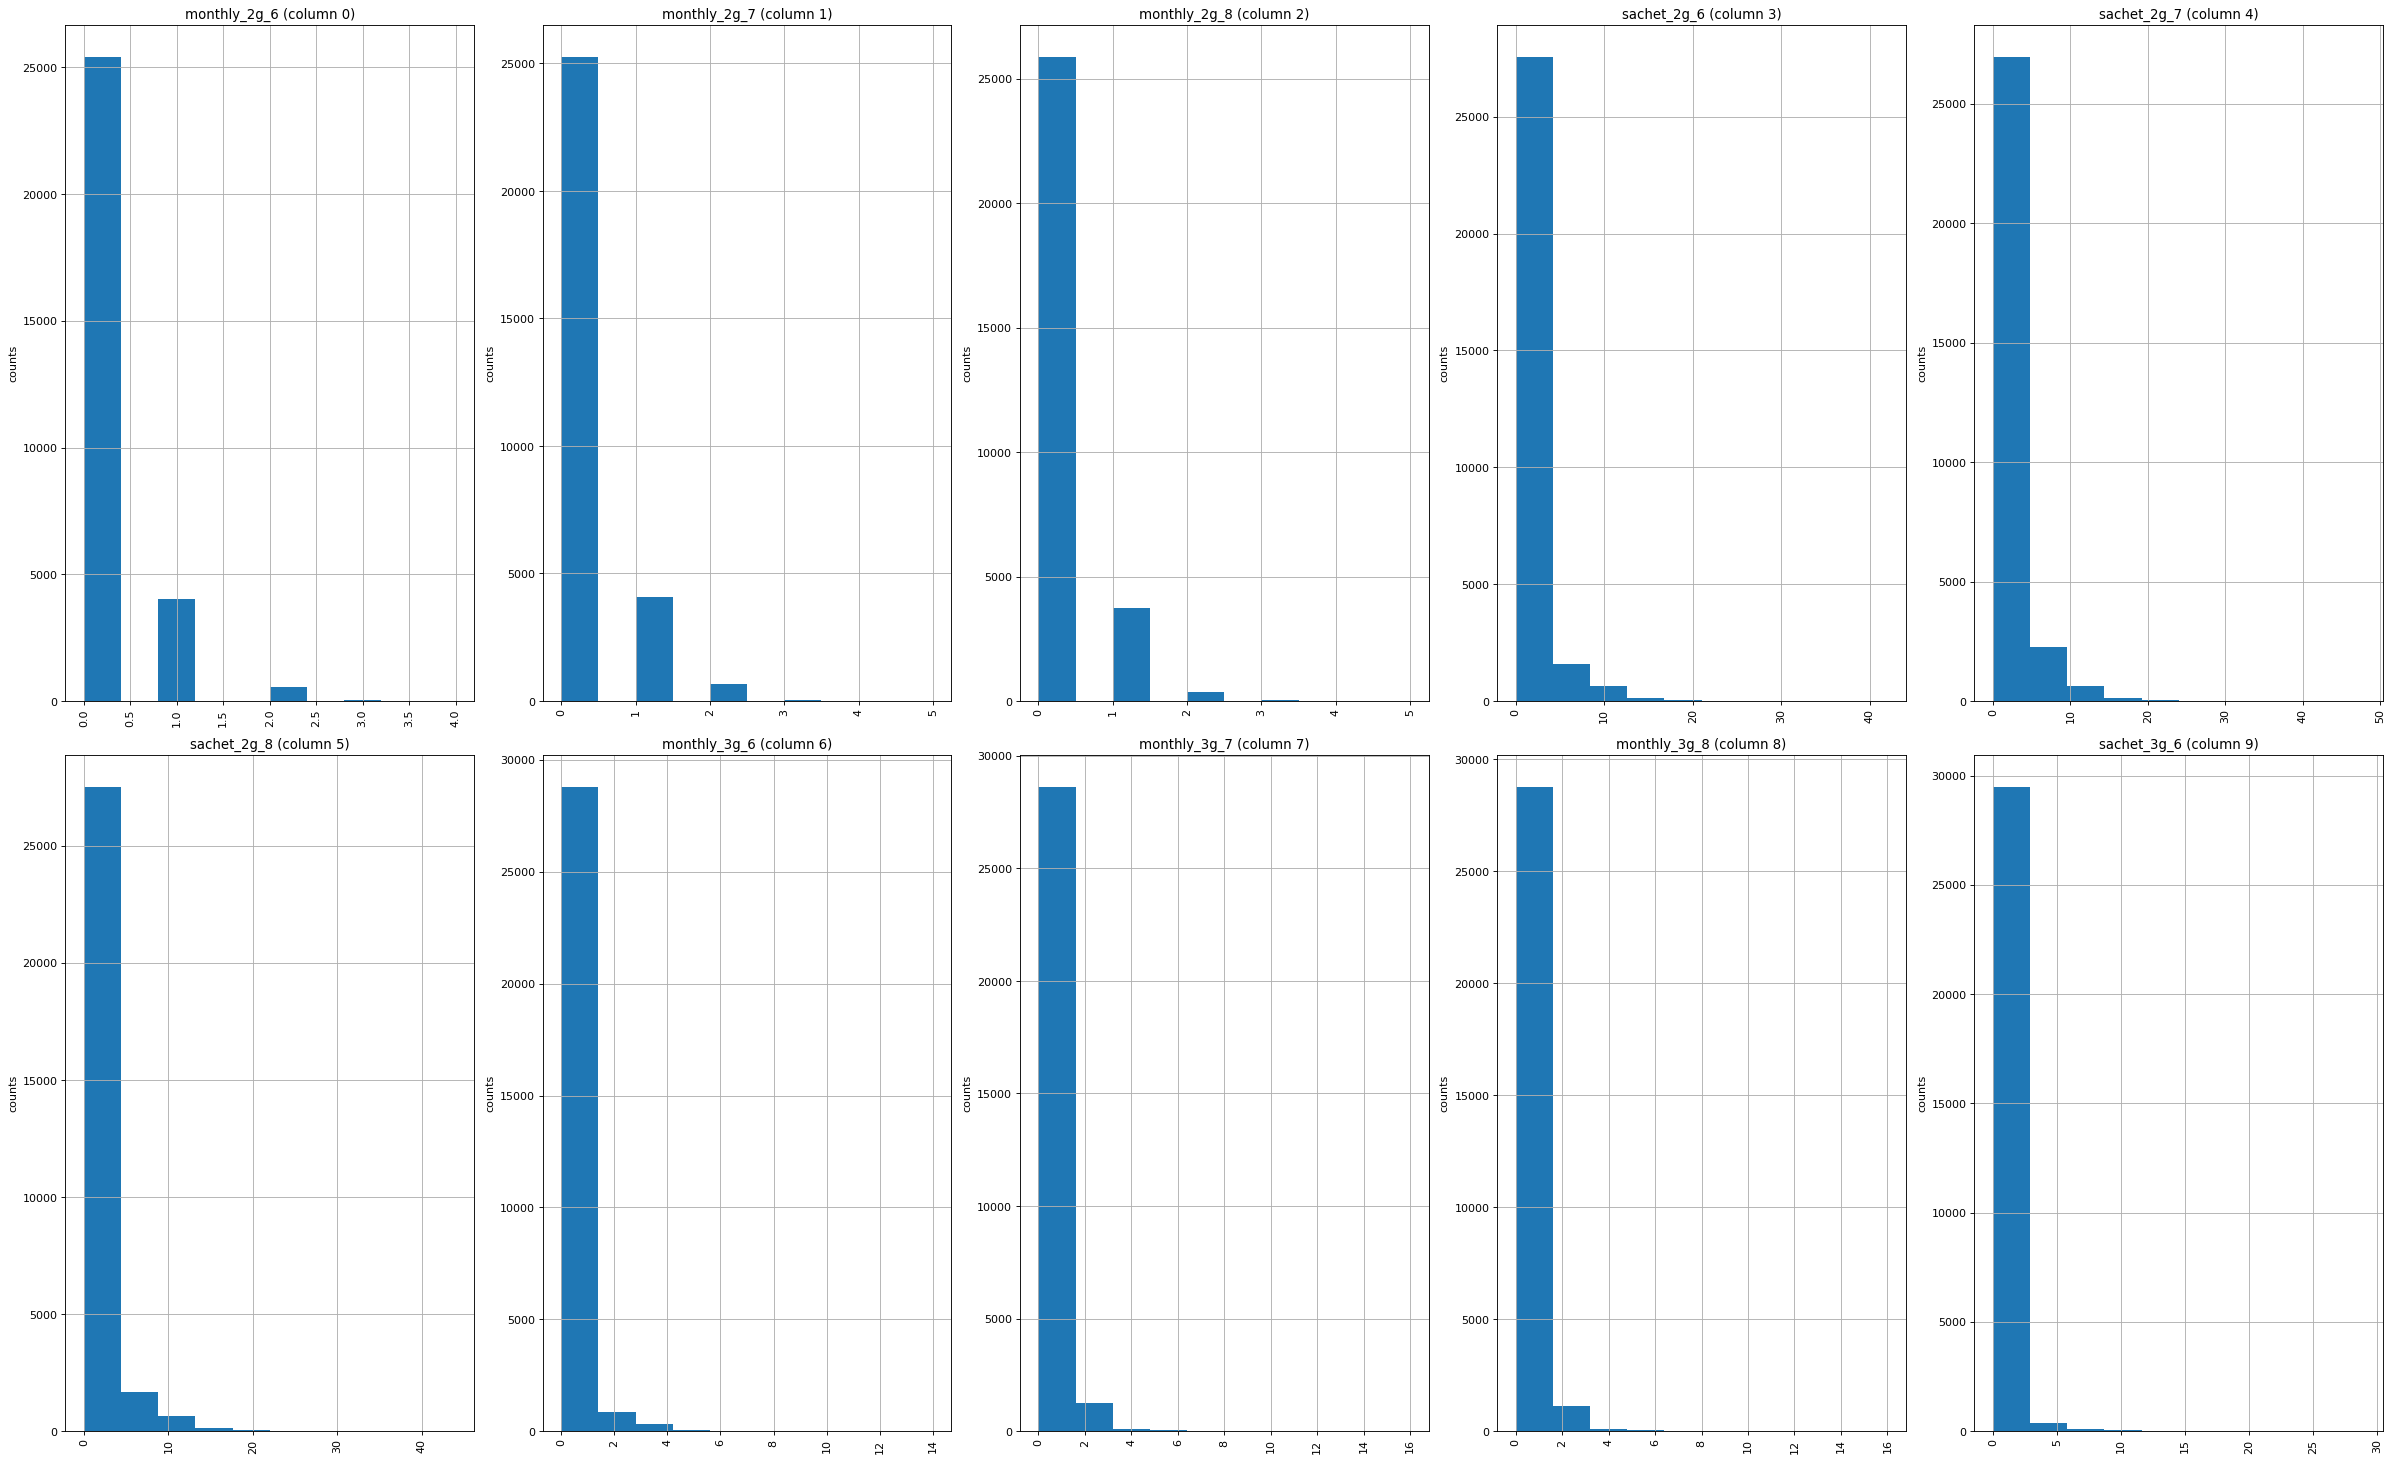

In [30]:
plotPerColumnDistribution(df_high_val_cust, 10, 5)

Correlation matrix:

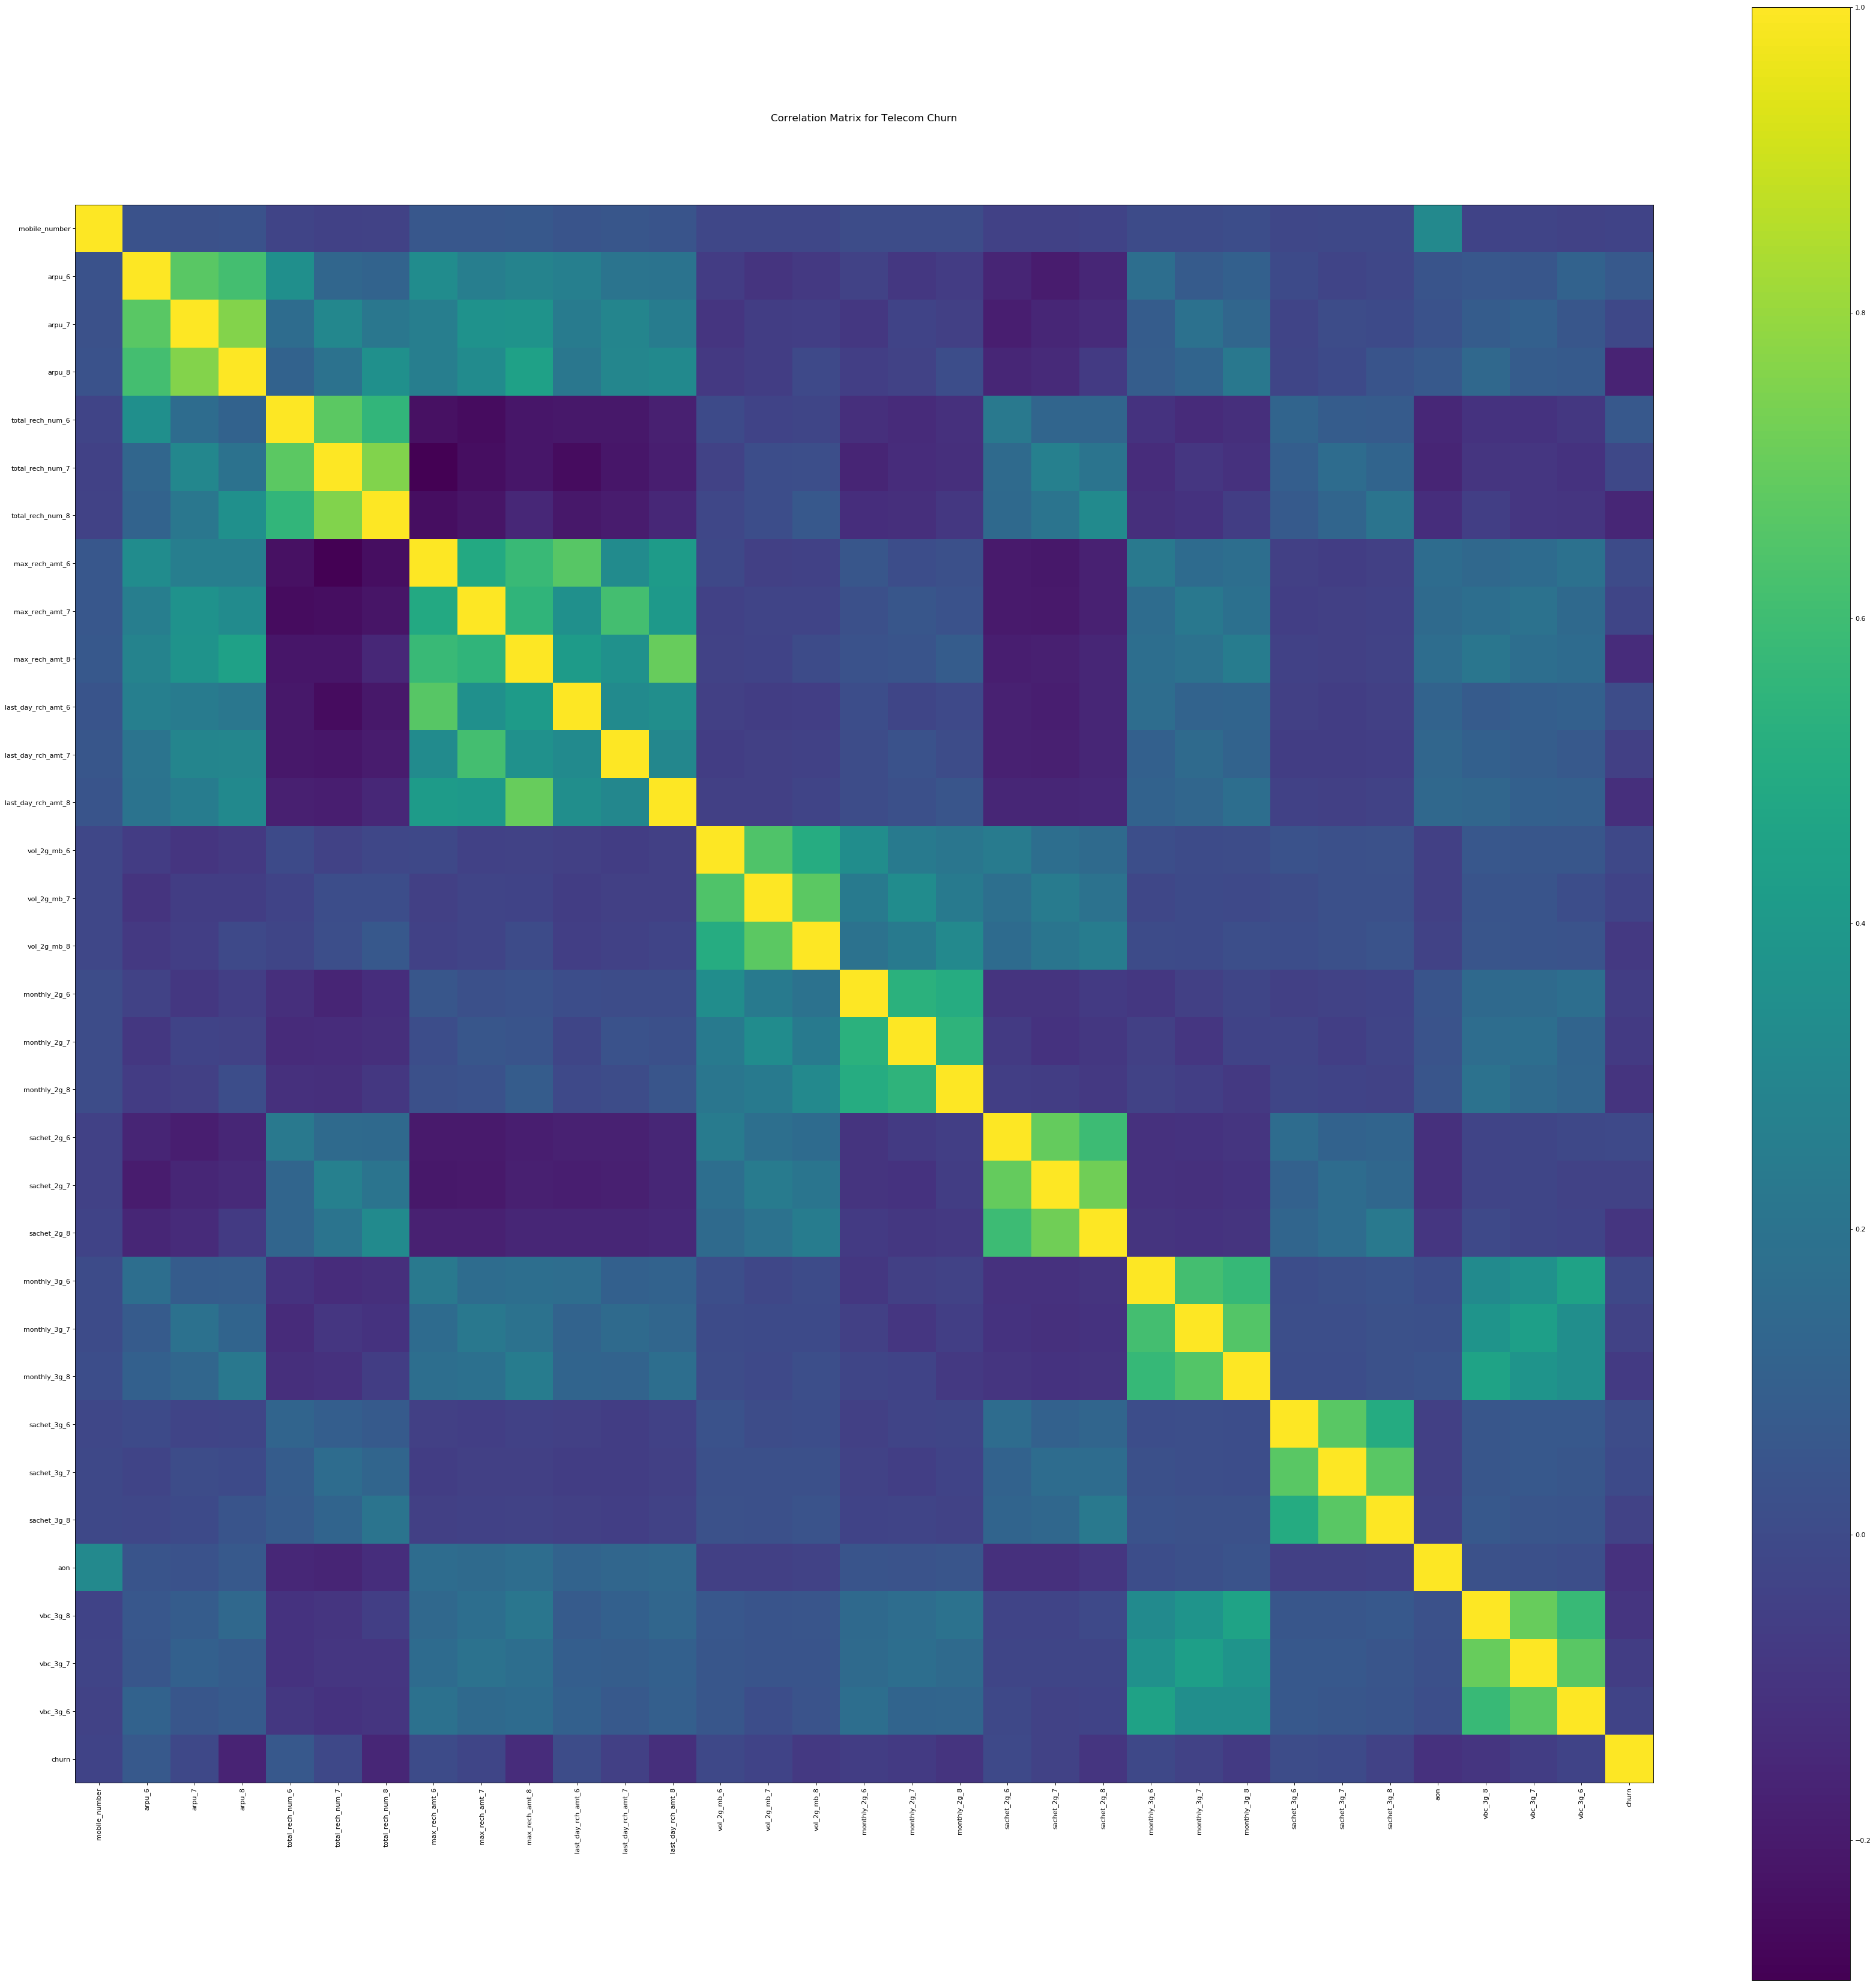

In [31]:
plotCorrelationMatrix(df_high_val_cust, 53)

Scatter and density plots:

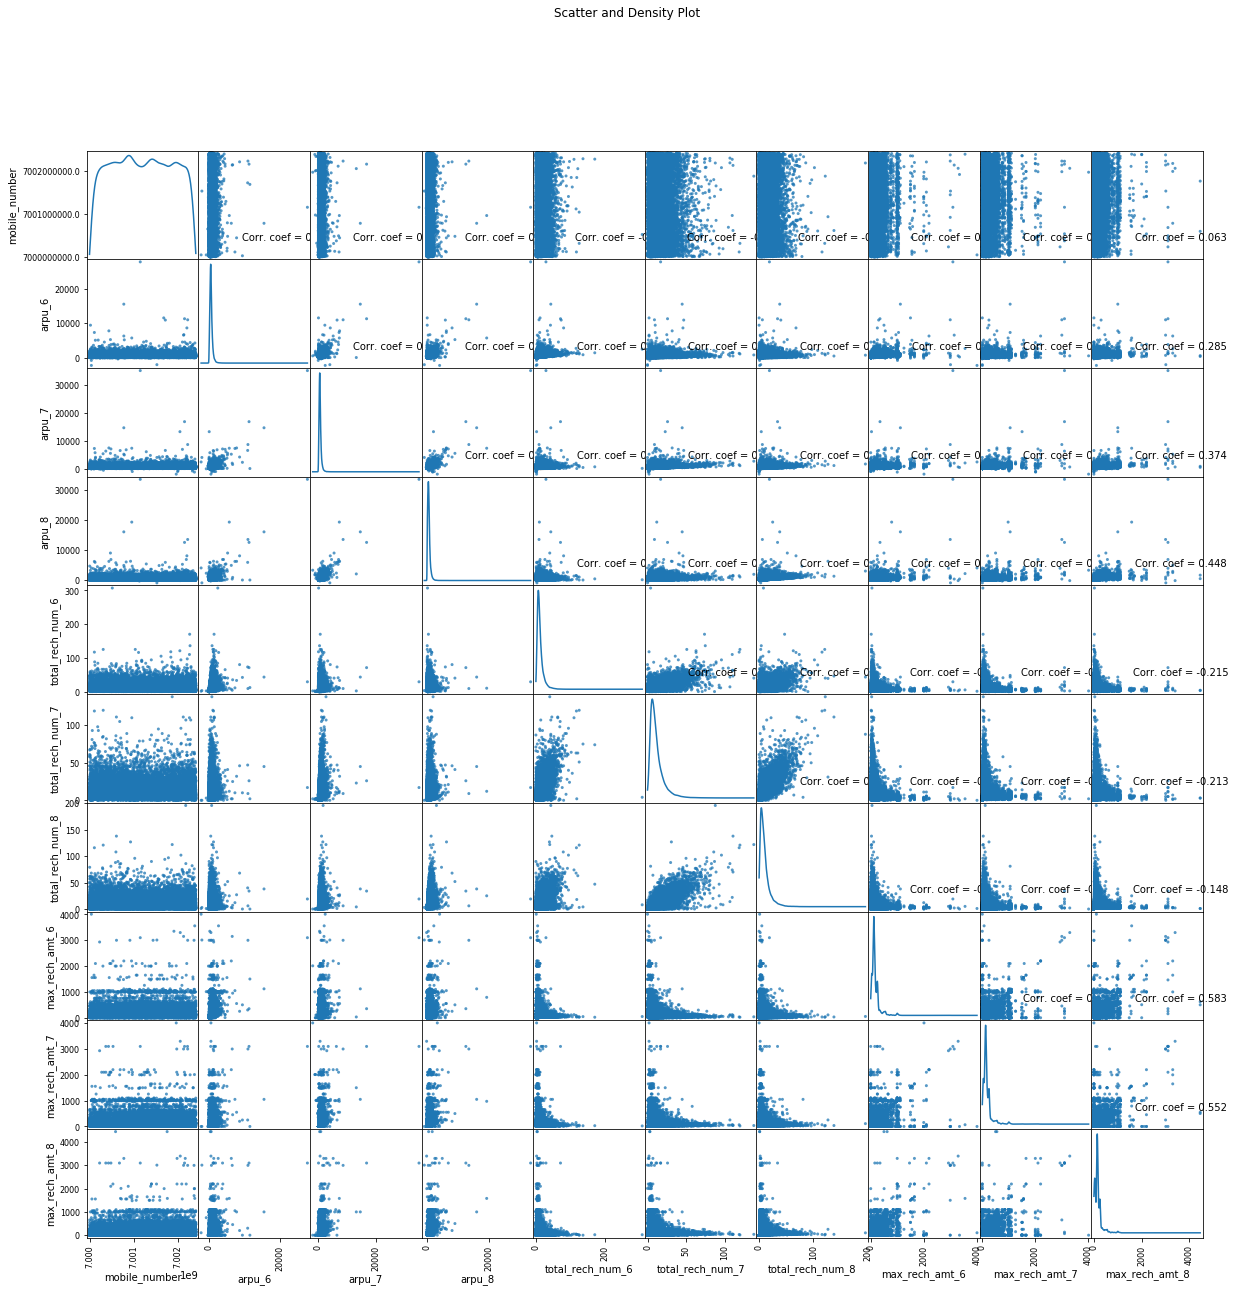

In [32]:
plotScatterMatrix(df_high_val_cust, 20, 10)

In [33]:
# create box plot for  6th, 7th and 8th month
def plot_box_chart(attribute):
    plt.figure(figsize=(20,16))
    df = df_high_val_cust
    plt.subplot(2,3,1)
    sns.boxplot(data=df, y=attribute+"_6",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,2)
    sns.boxplot(data=df, y=attribute+"_7",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.subplot(2,3,3)
    sns.boxplot(data=df, y=attribute+"_8",x="churn",hue="churn",
                showfliers=False,palette=("plasma"))
    plt.show()

### a. Bivarivant analysis on Recharge amount related variables

In [34]:
recharge_amnt_columns =  df_high_val_cust.columns[df_high_val_cust.columns.str.contains('rech_amt')]
recharge_amnt_columns.tolist()

['max_rech_amt_6', 'max_rech_amt_7', 'max_rech_amt_8']

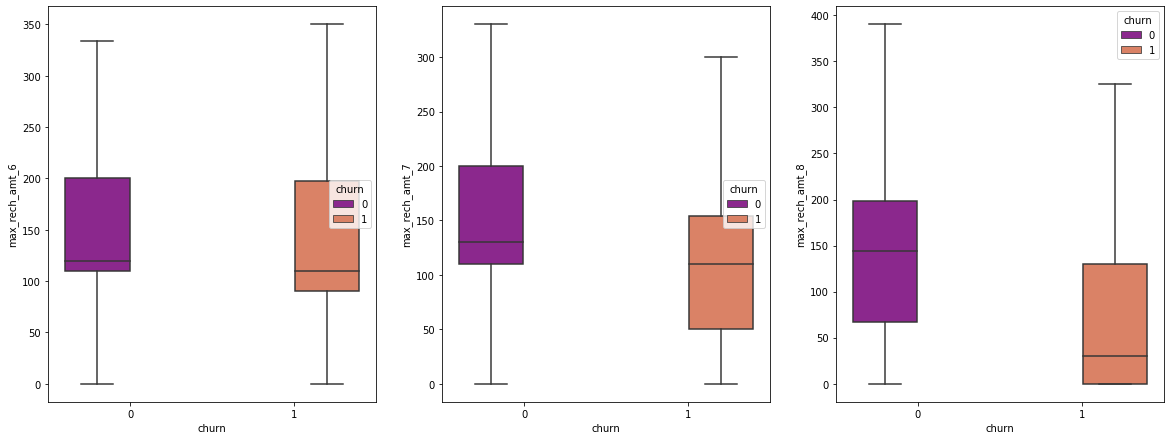

In [35]:
# Ploting for total recharge amount:
plot_box_chart('max_rech_amt')

> <span style='color:green'>**Analysis:** We can see that there is a huge drop in maximum recharge amount for data in the 8th month (action phase) for churned customers.

In [36]:
# Let's check other recharge related variables:
other_recharge = df_high_val_cust.columns[df_high_val_cust.columns.str.contains('rech_num|max_rech_data',regex=True)]

In [37]:
# lets check the % of NA values for other recharge related variables
100*df_high_val_cust.loc[:,other_recharge].isnull().sum()/len(df_high_val_cust)

total_rech_num_6                   0.00
total_rech_num_7                   0.00
total_rech_num_8                   0.00
dtype: float64

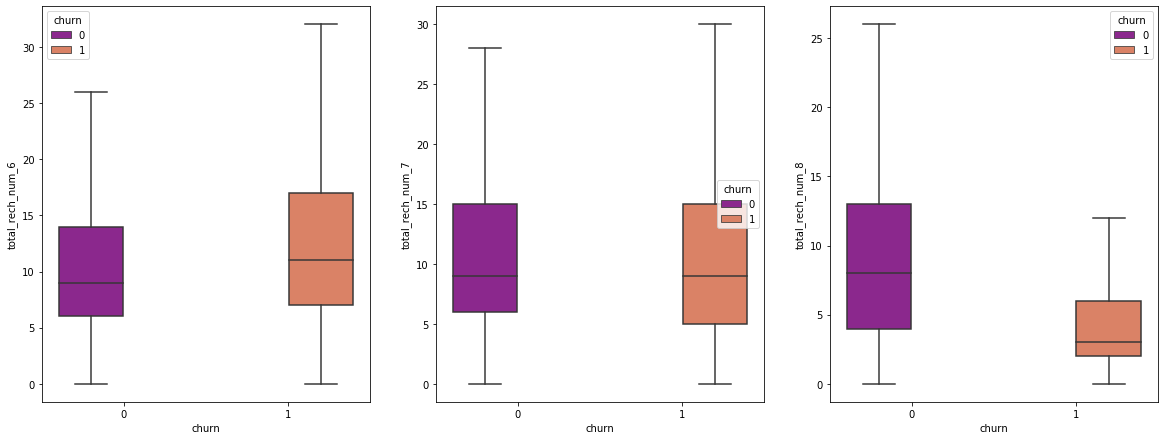

In [38]:
# Ploting for Total recharge for Number:
plot_box_chart('total_rech_num')

> <span style='color:green'>**Analysis:** We can see that there is a huge drop in total recharge number also in the 8th month (action phase) for churned customers.

### b.  Bivariant analysis on 2G and 3G usage related attributes

In [39]:
# let's check monthly 2G/3G service schemes
monthly_subcription_2g_3g = df_high_val_cust.columns[df_high_val_cust.columns.str.contains('monthly_2g|monthly_3g',regex=True)]
monthly_subcription_2g_3g.tolist()

['monthly_2g_6',
 'monthly_2g_7',
 'monthly_2g_8',
 'monthly_3g_6',
 'monthly_3g_7',
 'monthly_3g_8']

In [40]:
df_high_val_cust[monthly_subcription_2g_3g].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30001 entries, 0 to 99997
Data columns (total 6 columns):
 #   Column        Non-Null Count  Dtype
---  ------        --------------  -----
 0   monthly_2g_6  30001 non-null  int64
 1   monthly_2g_7  30001 non-null  int64
 2   monthly_2g_8  30001 non-null  int64
 3   monthly_3g_6  30001 non-null  int64
 4   monthly_3g_7  30001 non-null  int64
 5   monthly_3g_8  30001 non-null  int64
dtypes: int64(6)
memory usage: 2.9 MB


In [41]:
def plot_mean_bar_chart(df,columns_list):
    df_0 = df[df.churn==0].filter(columns_list)
    df_1 = df[df.churn==1].filter(columns_list)

    mean_df_0 = pd.DataFrame([df_0.mean()],index={'Non Churn'})
    mean_df_1 = pd.DataFrame([df_1.mean()],index={'Churn'})

    frames = [mean_df_0, mean_df_1]
    mean_bar = pd.concat(frames)

    mean_bar.T.plot.bar(figsize=(10,5),rot=0)
    plt.show()
    
    return mean_bar

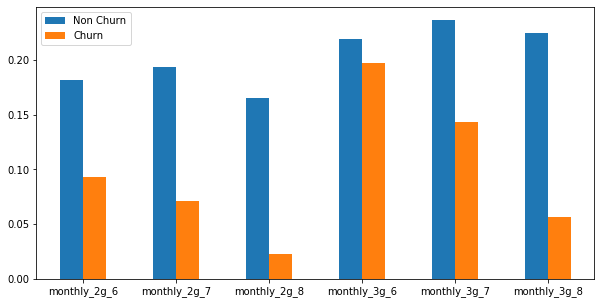

,monthly_2g_6,monthly_2g_7,monthly_2g_8,monthly_3g_6,monthly_3g_7,monthly_3g_8
Non Churn,0.18,0.19,0.17,0.22,0.24,0.22
Churn,0.09,0.07,0.02,0.20,0.14,0.06


In [42]:
plot_mean_bar_chart(df_high_val_cust, monthly_subcription_2g_3g)

> <span style='color:green'>**Analysis:** Again we can see a drop in monthly subscription for churned customers in 8th Month.

### c.  Bivariant onTenure Analysis for Customers  

In [43]:
tenure_data = df_high_val_cust.copy()

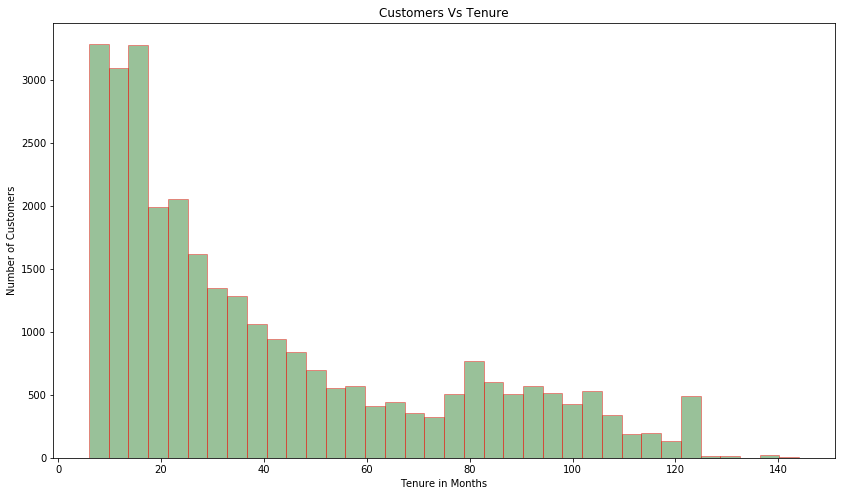

In [44]:
plt.figure(figsize=(14,8))
# aon --> Age on network - number of days the customer is using the operator T network
tenure_data['tenure'] = tenure_data['aon']/30
tenure_data['tenure'].head()
ax = sns.distplot(tenure_data['tenure'], hist=True, kde=False, 
             bins=int(180/5), color = 'darkgreen', 
             hist_kws={'edgecolor':'red'},
             kde_kws={'linewidth': 4})
ax.set_ylabel('Number of Customers')
ax.set_xlabel('Tenure in Months')
ax.set_title('Customers Vs Tenure')
plt.show()

In [47]:
tn_range = [0, 6, 12, 24, 60, 61]
tn_label = [ '0-6 Months', '6-12 Months', '1-2 Yrs', '2-5 Yrs', '5 Yrs and above']
tenure_data['tenure_range'] = pd.cut(tenure_data['tenure'], tn_range, labels=tn_label)
tenure_data['tenure_range'].head()

0         2-5 Yrs
7         2-5 Yrs
8     6-12 Months
21        1-2 Yrs
23        1-2 Yrs
Name: tenure_range, dtype: category
Categories (5, object): [0-6 Months < 6-12 Months < 1-2 Yrs < 2-5 Yrs < 5 Yrs and above]

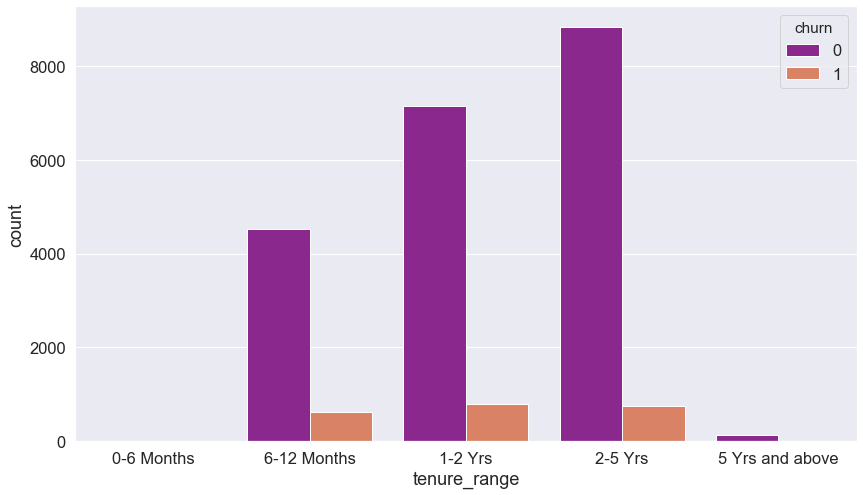

In [48]:
plt.figure(figsize=(14,8))
sns.countplot(x = 'tenure_range', hue = 'churn',data = tenure_data,palette=("plasma"))
plt.show()

> <span style='color:green'>**Analysis:** We also see that mostly you are with longer time with the network are less chance to become churn

### d.Bivariant anaysis on Minutes of usage - voice calls

In [49]:
mou_cols = df_high_val_cust.columns[df_high_val_cust.columns.str.contains('mou')]

In [50]:
mou_cols

Index(['onnet_mou_6', 'onnet_mou_7', 'onnet_mou_8', 'offnet_mou_6',
       'offnet_mou_7', 'offnet_mou_8', 'roam_ic_mou_6', 'roam_ic_mou_7',
       'roam_ic_mou_8', 'roam_og_mou_6', 'roam_og_mou_7', 'roam_og_mou_8',
       'loc_og_t2c_mou_6', 'loc_og_t2c_mou_7', 'loc_og_t2c_mou_8',
       'loc_og_mou_6', 'loc_og_mou_7', 'loc_og_mou_8', 'std_og_t2f_mou_6',
       'std_og_t2f_mou_7', 'std_og_t2f_mou_8', 'std_og_mou_6', 'std_og_mou_7',
       'std_og_mou_8', 'isd_og_mou_6', 'isd_og_mou_7', 'isd_og_mou_8',
       'spl_og_mou_6', 'spl_og_mou_7', 'spl_og_mou_8', 'loc_ic_mou_6',
       'loc_ic_mou_7', 'loc_ic_mou_8', 'std_ic_t2t_mou_6', 'std_ic_t2t_mou_7',
       'std_ic_t2t_mou_8', 'std_ic_t2f_mou_6', 'std_ic_t2f_mou_7',
       'std_ic_t2f_mou_8', 'std_ic_mou_6', 'std_ic_mou_7', 'std_ic_mou_8',
       'spl_ic_mou_6', 'spl_ic_mou_7', 'spl_ic_mou_8', 'isd_ic_mou_6',
       'isd_ic_mou_7', 'isd_ic_mou_8'],
      dtype='object')

In [51]:
meta_df = get_meta_data(df_high_val_cust[mou_cols])
meta_df.sort_values(["Null_Percentage"], axis=0,ascending=False, inplace=True)
col_to_display = ['Null_Percentage']
meta_df[col_to_display]

,Null_Percentage
isd_ic_mou_8,3.91
std_ic_t2f_mou_8,3.91
std_og_t2f_mou_8,3.91
spl_og_mou_8,3.91
loc_og_mou_8,3.91
loc_ic_mou_8,3.91
loc_og_t2c_mou_8,3.91
std_ic_t2t_mou_8,3.91
std_og_mou_8,3.91
roam_og_mou_8,3.91


> <span style='color:green'>**Analysis:** So for all minutes of usage columns the maximum missing % is 3.91 , means in these case the customer has not been used at all for that particular call type

### 4. Reduce the No of Columns by Creating New Meaningful Features

Create Columns with Average of 6th & 7th Month Since it's a "Good" Phase and Keep the 8th month untouched as it's "Action" Phase, for now to see if it can give any additional insight

In [52]:
col_list = df_high_val_cust.filter(regex='_6|_7').columns.str[:-2]
col_list.unique()

print (df_high_val_cust.shape)

for idx, col in enumerate(col_list.unique()):
    print(col)
    avg_col_name = "avg_"+col+"_av67"
    col_6 = col+"_6"
    col_7 = col+"_7"
    df_high_val_cust[avg_col_name] = (df_high_val_cust[col_6]  + df_high_val_cust[col_7])/ 2



(30001, 87)
arpu
onnet_mou
offnet_mou
roam_ic_mou
roam_og_mou
loc_og_t2c_mou
loc_og_mou
std_og_t2f_mou
std_og_mou
isd_og_mou
spl_og_mou
og_others
loc_ic_mou
std_ic_t2t_mou
std_ic_t2f_mou
std_ic_mou
spl_ic_mou
isd_ic_mou
ic_others
total_rech_num
max_rech_amt
last_day_rch_amt
vol_2g_mb
monthly_2g
sachet_2g
monthly_3g
sachet_3g
vbc_3g


In [53]:
print (df_high_val_cust.shape)

col_list = df_high_val_cust.filter(regex='_6|_7').columns

df_high_val_cust.drop(col_list, axis=1, inplace=True)
df_high_val_cust.shape

(30001, 115)


(30001, 59)

In [54]:
df_high_val_cust.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,...,avg_ic_others_av67,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,nan,3.50,252.00,252.00,15.72,0.00,0.00,1.00,0.00,50.60
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,...,15.46,5.00,"1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,19.06
8,7001524846,137.36,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,...,0.00,20.00,122.00,25.00,178.00,0.50,0.50,0.00,0.00,516.40
21,7002124215,637.76,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,...,0.00,24.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,...,2.67,4.00,89.50,89.50,0.24,0.00,0.00,1.00,0.00,25.93


In [55]:
#Conevrt AON in Months
df_high_val_cust['aon_mon'] = df_high_val_cust['aon']/30
df_high_val_cust.drop('aon', axis=1, inplace=True)
df_high_val_cust['aon_mon'].head()

0                   32.27
7                   26.73
8                   10.50
21                  24.00
23                  20.13
Name: aon_mon, dtype: float64

Distribution graphs (histogram/bar graph) of sampled columns:

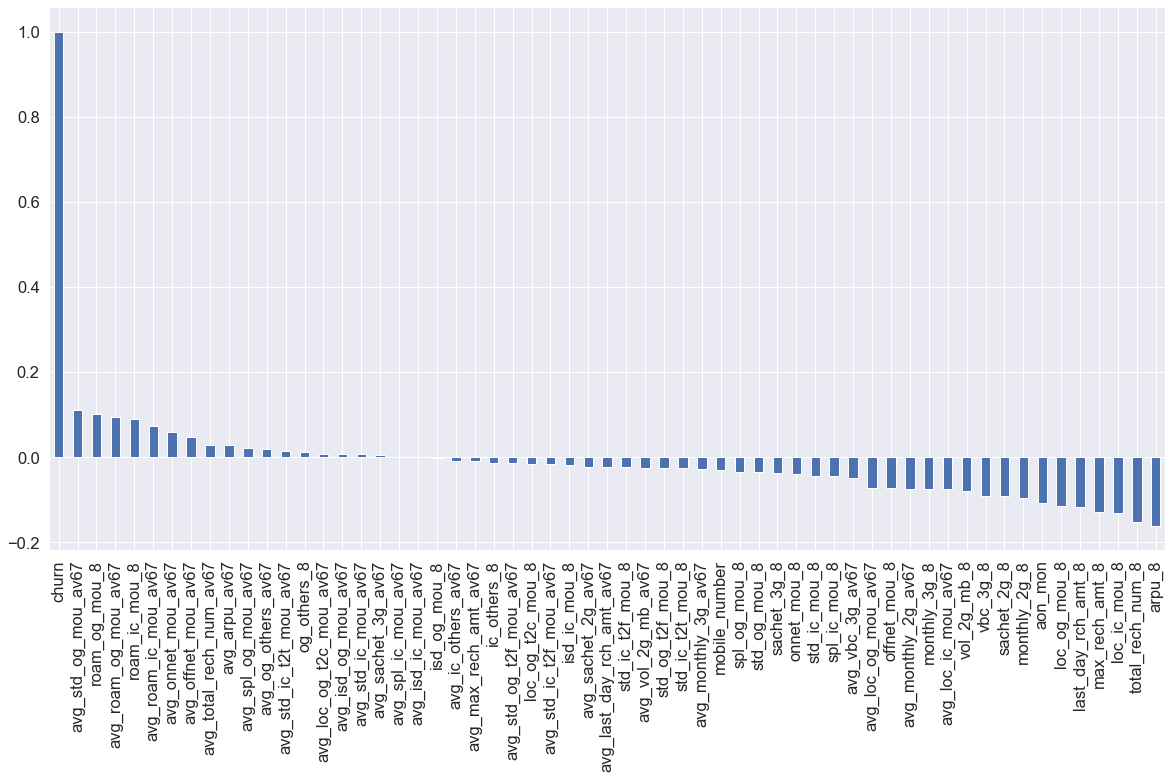

In [59]:
#Get Correlation of "Churn" with other variables:
plt.figure(figsize=(20,10))
df_high_val_cust.corr()['churn'].sort_values(ascending = False).plot(kind='bar')

Avg STD Outgoing Calls for Month 6 & 7, Outgoing calls in Roaming seems to be positively correlated with Churn while Avg Revenue, No Of Recharge for 8th Month seems negatively correlated.

Lets look at the relation between total recharge in 8th Month Vs Average Revenue in 8th Month

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


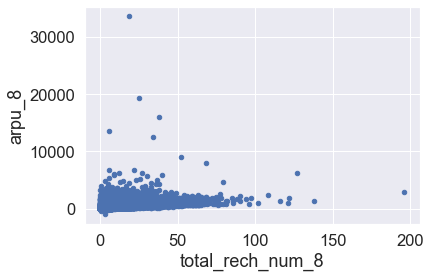

In [60]:
df_high_val_cust[['total_rech_num_8', 'arpu_8']].plot.scatter(x = 'total_rech_num_8',
                                                              y='arpu_8')

Lets look at the relation between Tenure And Revenue

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


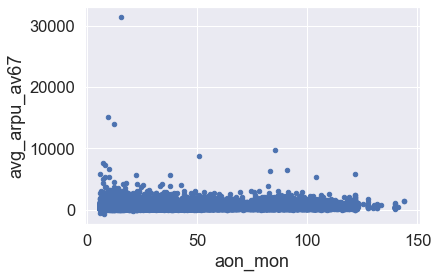

In [61]:
df_high_val_cust[['aon_mon', 'avg_arpu_av67']].plot.scatter(x = 'aon_mon',
                                                              y='avg_arpu_av67')

Finally, let's take a look at out predictor variable (Churn) and understand its interaction with other important variables as was found out in the correlation plot.

#### Churn vs Tenure 

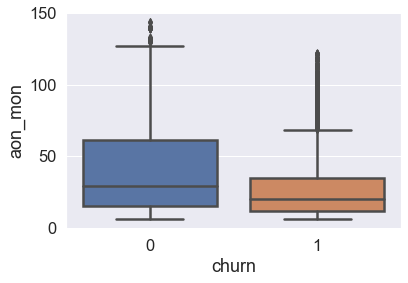

In [62]:
sns.boxplot(x = df_high_val_cust.churn, y = df_high_val_cust.aon_mon)


As we can see form the below plot, the customers who do not churn, they tend to stay for a longer tenure with the telecom company.

#### Churn Vs Volume based cost

Text(0.5, 1.0, 'Distribution of Volume based cost by churn')

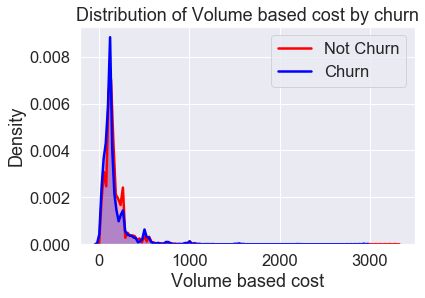

In [63]:
ax = sns.kdeplot(df_high_val_cust.avg_max_rech_amt_av67[(df_high_val_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(df_high_val_cust.avg_max_rech_amt_av67[(df_high_val_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Volume based cost by churn')

#### Churn Vs Max Recharge Amount

Text(0.5, 1.0, 'Distribution of Max Recharge Amount by churn')

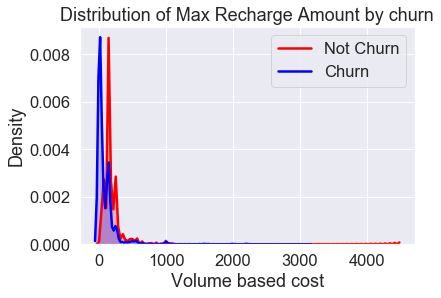

In [64]:
ax = sns.kdeplot(df_high_val_cust.max_rech_amt_8[(df_high_val_cust["churn"] == 0)],
                color="Red", shade = True)
ax = sns.kdeplot(df_high_val_cust.max_rech_amt_8[(df_high_val_cust["churn"] == 1)],
                ax =ax, color="Blue", shade= True)
ax.legend(["Not Churn","Churn"],loc='upper right')
ax.set_ylabel('Density')
ax.set_xlabel('Volume based cost')
ax.set_title('Distribution of Max Recharge Amount by churn')

* People Who Recharge with less Amount are more likely to Churn
* There is no visible difference in Volume Based Cost & Churn

In [56]:
df_high_val_cust.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,...,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,aon_mon
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.50,252.00,252.00,15.72,0.00,0.00,1.00,0.00,50.60,32.27
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,...,5.00,"1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,19.06,26.73
8,7001524846,137.36,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,...,20.00,122.00,25.00,178.00,0.50,0.50,0.00,0.00,516.40,10.50
21,7002124215,637.76,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,...,24.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,...,4.00,89.50,89.50,0.24,0.00,0.00,1.00,0.00,25.93,20.13


### 5. Data frame for Model Building 

In [58]:
#Lets Create New DF for Model Building

df = df_high_val_cust[:].copy()

#Dropping tenure_range since we have AON MONTH already and columns are highly coorelated
#df.drop('tenure_range', axis=1, inplace=True)
#df.drop('mobile_number', axis=1, inplace=True)

#Since All The Values are realted to Price/ Cost/ Amount, Filling NaN with 0

df.fillna(0, inplace=True)

df.head()

,mobile_number,arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8,loc_og_t2c_mou_8,loc_og_mou_8,std_og_t2f_mou_8,std_og_mou_8,...,avg_total_rech_num_av67,avg_max_rech_amt_av67,avg_last_day_rch_amt_av67,avg_vol_2g_mb_av67,avg_monthly_2g_av67,avg_sachet_2g_av67,avg_monthly_3g_av67,avg_sachet_3g_av67,avg_vbc_3g_av67,aon_mon
0,7000842753,213.80,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,...,3.50,252.00,252.00,15.72,0.00,0.00,1.00,0.00,50.60,32.27
7,7000701601,"3,171.48",52.29,325.91,31.64,38.06,0.00,255.79,16.68,77.84,...,5.00,"1,185.00",0.00,0.00,0.00,0.00,0.00,0.00,19.06,26.73
8,7001524846,137.36,35.08,136.48,0.00,0.00,7.15,63.04,0.00,98.28,...,20.00,122.00,25.00,178.00,0.50,0.50,0.00,0.00,516.40,10.50
21,7002124215,637.76,85.14,983.39,0.00,0.00,0.00,129.74,0.00,938.79,...,24.00,50.00,25.00,0.00,0.00,0.00,0.00,0.00,0.00,24.00
23,7000887461,366.97,33.58,205.89,0.00,0.00,17.71,182.14,0.00,39.61,...,4.00,89.50,89.50,0.24,0.00,0.00,1.00,0.00,25.93,20.13


In [59]:
X = df.drop(['churn'], axis=1)
y = df['churn']

df.drop('churn', axis=1, inplace=True)


In [60]:
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

scaler = preprocessing.StandardScaler().fit(X)
X = scaler.transform(X)

In [61]:
# Split in train & Test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

In [62]:
print("X_train Shape : ", X_train.shape)
print("X_test Shape : ", X_test.shape)

y_train_imb = (y_train != 0).sum()/(y_train == 0).sum()
y_test_imb = (y_test != 0).sum()/(y_test == 0).sum()
print("Imbalance in Train Data : ", y_train_imb)
print("Imbalance in Test Data : ", y_test_imb)

X_train Shape :  (21000, 58)
X_test Shape :  (9001, 58)
Imbalance in Train Data :  0.08875985068436333
Imbalance in Test Data :  0.08812862669245648


Text(0.5, 1.0, 'Churn Distribution')

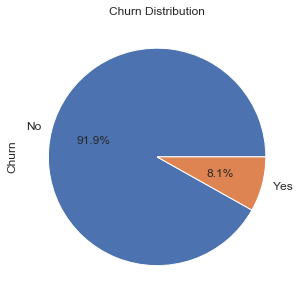

In [65]:
#Churn Distribution
ax = (df_high_val_cust['churn'].value_counts()*100.0 /len(df_high_val_cust)).plot.pie(autopct='%.1f%%', labels = ['No', 'Yes'],figsize =(5,5), fontsize = 12 )                                                                           

ax.set_ylabel('Churn',fontsize = 12)
ax.set_title('Churn Distribution', fontsize = 12)

> <span style='color:green'>**In our data, 91% of the customers do not churn. Clearly the data is skewed as we would expect a large majority of the customers to not churn. This is important to keep in mind for our modelling as skeweness could lead to a lot of false negatives. We will see in the modelling section on how to avoid skewness in the data.

In [66]:
# Balancing DataSet
from imblearn.over_sampling import SMOTE

sm = SMOTE()
X_tr,y_tr = sm.fit_sample(X_train,y_train)

In [67]:
print("X_tr Shape", X_tr.shape)
print("y_tr Shape", y_tr.shape)

imb = (y_tr != 0).sum()/(y_tr == 0).sum()
print("Imbalance in Train Data : ",imb)

X_tr Shape (38576, 58)
y_tr Shape (38576,)
Imbalance in Train Data :  1.0


> <span style='color:green'>**Analysis:** SMOTE bloated the dataset and balanced it by adding skewed data values.

### 6. Model Building

 Let's fist build two basic models - linear and non-linear with default hyperparameters, and compare the accuracies.

### Support Vecor Machine (SVM)

In [68]:
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn import metrics

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=99)

lr = LogisticRegression()

lr.svm = SVC(kernel='linear') 
lr.svm.fit(X_train,y_train)
preds = lr.svm.predict(X_test)
metrics.accuracy_score(y_test, preds)

0.9170138310281619

### RFE

In [69]:
# Feature reduction using RFE
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression()
from sklearn.feature_selection import RFE

# running RFE with 15 variables as output
rfe = RFE(lr, 15)   
rfe = rfe.fit(X_tr, y_tr)

In [70]:
rfe_features = list(df.columns[rfe.support_])
print("Features identified by RFE ", rfe_features)

Features identified by RFE  ['loc_og_mou_8', 'og_others_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'avg_arpu_av67', 'avg_loc_ic_mou_av67', 'avg_ic_others_av67', 'avg_total_rech_num_av67']


In [71]:
X_rfe = pd.DataFrame(data=X_tr).iloc[:, rfe.support_]
y_rfe = y_tr

### Logistic Regression

In [72]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=1)
lr.fit(X_rfe, y_rfe)

LogisticRegression(random_state=1)

In [73]:
X_test_rfe = pd.DataFrame(data=X_test).iloc[:, rfe.support_]

y_pred = lr.predict(X_test_rfe)

from sklearn.metrics import confusion_matrix
confusion_matrix = confusion_matrix(y_test, y_pred)
print(confusion_matrix)

[[4442 1061]
 [  86  412]]


In [74]:
print('Accuracy of Logistic Regression Model on test set is ',lr.score(X_test_rfe, y_test))

Accuracy of Logistic Regression Model on test set is  0.8088651891351442


In [75]:
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.98      0.81      0.89      5503
           1       0.28      0.83      0.42       498

    accuracy                           0.81      6001
   macro avg       0.63      0.82      0.65      6001
weighted avg       0.92      0.81      0.85      6001



> <span style='color:blue'>**Analysis:** The plots above show some useful insights:
>> - Non-linear models (high gamma) perform *much better* than the linear ones
>> - At any value of gamma, a high value of C leads to better performance
>> - Model with gamma = 0.1 tends to overfit and rest of the values seems to be good. 
>> - This suggests that the problem and the data is **inherently non-linear** in nature, and a complex model will outperform simple, linear models in this case.</span>

In [76]:
# To get the weights of all the variables
weights = pd.Series(lr.coef_[0],
                 index=rfe_features)
weights.sort_values(ascending = False)

avg_loc_ic_mou_av67                       0.63
avg_arpu_av67                             0.49
avg_total_rech_num_av67                   0.33
avg_ic_others_av67                       -0.23
spl_ic_mou_8                             -0.31
vol_2g_mb_8                              -0.31
std_ic_mou_8                             -0.43
monthly_3g_8                             -0.46
last_day_rch_amt_8                       -0.50
sachet_2g_8                              -0.62
monthly_2g_8                             -0.67
loc_og_mou_8                             -0.89
total_rech_num_8                         -0.90
og_others_8                              -2.61
loc_ic_mou_8                             -2.76
dtype: float64

LR Summary
* Model Accuracy is 79%
* Confusion matix clearly shows that the model has drawback in predicting churn as high false positives.

### PCA

In [77]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

#Applying Smote
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)


(38576, 58)
(38576,)


Applying  PCA

In [78]:
#Improting the PCA module
from sklearn.decomposition import PCA
pca = PCA(random_state=100)

#Doing the PCA on the train data
pca.fit(X_tr)

PCA(random_state=100)

In [79]:
X_tr_pca = pca.fit_transform(X_tr)
print(X_tr_pca.shape)

X_test_pca = pca.transform(X_test)
print(X_test_pca.shape)

(38576, 58)
(9001, 58)


Applying logistic regression


In [80]:
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca = LogisticRegression(C=1e9)
lr_pca.fit(X_tr_pca, y_tr)

# Predicted probabilities
y_pred = lr_pca.predict(X_test_pca)

# Converting y_pred to a dataframe which is an array
y_pred_df = pd.DataFrame(y_pred)

In [81]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Printing confusion matrix
print(confusion_matrix(y_test,y_pred))

[[6758 1514]
 [ 129  600]]


In [82]:
print("Logistic Regression accuracy with PCA: ",accuracy_score(y_test,y_pred))

Logistic Regression accuracy with PCA:  0.8174647261415399


In [83]:
col = list(df.columns)
df_pca = pd.DataFrame({'PC1':pca.components_[0],'PC2':pca.components_[1], 'PC3':pca.components_[2],'Feature':col})
df_pca.head(10)

,PC1,PC2,PC3,Feature
0,0.04,0.01,0.08,mobile_number
1,0.26,-0.09,0.17,arpu_8
2,0.16,-0.19,-0.00,onnet_mou_8
3,0.21,-0.16,0.07,offnet_mou_8
4,0.31,0.31,-0.19,roam_ic_mou_8
5,0.27,0.19,-0.17,roam_og_mou_8
6,0.03,-0.06,0.00,loc_og_t2c_mou_8
7,0.12,-0.09,0.20,loc_og_mou_8
8,0.04,0.01,0.08,std_og_t2f_mou_8
9,0.17,-0.25,-0.04,std_og_mou_8


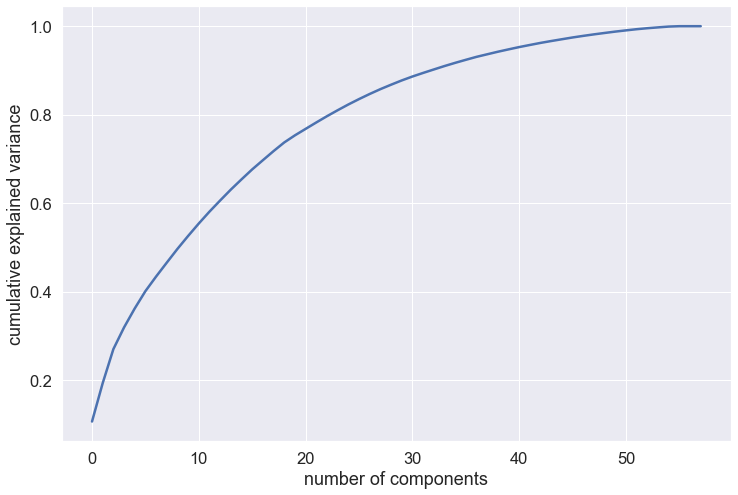

In [84]:
#Making the screeplot - plotting the cumulative variance against the number of components
%matplotlib inline
fig = plt.figure(figsize = (12,8))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

In [85]:
np.cumsum(np.round(pca.explained_variance_ratio_, decimals=4)*100)

array([ 10.63,  19.31,  27.  ,  31.91,  36.2 ,  40.11,  43.41,  46.56,
        49.67,  52.6 ,  55.42,  58.1 ,  60.62,  63.08,  65.39,  67.64,
        69.72,  71.78,  73.73,  75.33,  76.79,  78.24,  79.65,  81.  ,
        82.3 ,  83.52,  84.68,  85.77,  86.77,  87.74,  88.63,  89.44,
        90.22,  90.99,  91.71,  92.4 ,  93.07,  93.65,  94.23,  94.77,
        95.29,  95.77,  96.24,  96.66,  97.06,  97.46,  97.82,  98.16,
        98.48,  98.79,  99.07,  99.34,  99.56,  99.75,  99.93, 100.02,
       100.02, 100.02])

Applying LR with 32 columns with 90% variance


In [86]:
pca_32 = PCA(n_components=32)

df_tr_pca_32 = pca_32.fit_transform(X_tr)
print(df_tr_pca_32.shape)

df_test_pca_32 = pca_32.transform(X_test)
print(df_test_pca_32.shape)

(38576, 32)
(9001, 32)


In [87]:
# Let's run the model using the selected variables
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
lr_pca1 = LogisticRegression(C=1e9)
lr_pca1.fit(df_tr_pca_32, y_tr)

# Predicted probabilities
y_pred32 = lr_pca1.predict(df_test_pca_32)

# Converting y_pred to a dataframe which is an array
df_y_pred = pd.DataFrame(y_pred32)

In [88]:
print(confusion_matrix(y_test,y_pred32))

[[6739 1533]
 [ 143  586]]


In [89]:
print("Logistic Regression accuracy with PCA: ",accuracy_score(y_test,y_pred32))

Logistic Regression accuracy with PCA:  0.8137984668370181


PCA Summary :
*  Model has 81% Accuracy
* 32 Features can obtain optimal accuracy with 90% Variance
* Main Features are arpu_8,onnet_mou_8,offnet_mou_8,roam_ic_mou_8,roam_og_mou_8

### Decision Tress

In [90]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, train_size=0.7, random_state=1)

#Applying Smote
from imblearn.over_sampling import SMOTE
sm = SMOTE()
X_tr,y_tr = sm.fit_sample(X_train,y_train)
print(X_tr.shape)
print(y_tr.shape)

(38576, 58)
(38576,)


Feature reduction using LASSO


In [91]:
from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel
 
lsvc = LinearSVC(C=0.001, penalty="l1", dual=False).fit(X_tr, y_tr)
model = SelectFromModel(lsvc, prefit=True)
X_lasso = model.transform(X_tr)
pos = model.get_support(indices=True)
 ### Feature reduction using RFE
print(X_lasso.shape)
print(pos)

(38576, 30)
[ 1  3  4  5  7  8  9 11 13 16 17 20 21 22 23 24 25 26 27 28 29 32 37 41
 48 49 51 52 53 57]


In [92]:
#feature vector for decision tree
lasso_features = list(df.columns[pos])
print("Features for LASSO model buidling: ", lasso_features)

Features for LASSO model buidling:  ['arpu_8', 'offnet_mou_8', 'roam_ic_mou_8', 'roam_og_mou_8', 'loc_og_mou_8', 'std_og_t2f_mou_8', 'std_og_mou_8', 'spl_og_mou_8', 'loc_ic_mou_8', 'std_ic_mou_8', 'spl_ic_mou_8', 'total_rech_num_8', 'max_rech_amt_8', 'last_day_rch_amt_8', 'vol_2g_mb_8', 'monthly_2g_8', 'sachet_2g_8', 'monthly_3g_8', 'sachet_3g_8', 'vbc_3g_8', 'avg_arpu_av67', 'avg_roam_ic_mou_av67', 'avg_std_og_mou_av67', 'avg_loc_ic_mou_av67', 'avg_total_rech_num_av67', 'avg_max_rech_amt_av67', 'avg_vol_2g_mb_av67', 'avg_monthly_2g_av67', 'avg_sachet_2g_av67', 'aon_mon']


Decision Tree with Default Hyperparameter

In [93]:
# Importing decision tree classifier from sklearn library
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

# Fitting the decision tree with default hyperparameters, apart from
# max_depth which is 5 so that we can plot and read the tree.
dt1 = DecisionTreeClassifier(max_depth=5)
dt1.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5)

In [94]:
# The evaluation metrics of our default model
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# Making predictions
X_test = pd.DataFrame(data=X_test).iloc[:, pos]
y_pred1 = dt1.predict(X_test)

# Printing classification report
print(classification_report(y_test, y_pred1))

              precision    recall  f1-score   support

           0       0.98      0.89      0.93      8272
           1       0.37      0.77      0.50       729

    accuracy                           0.88      9001
   macro avg       0.68      0.83      0.72      9001
weighted avg       0.93      0.88      0.90      9001



In [95]:
# Printing confusion matrix and accuracy
print(confusion_matrix(y_test,y_pred1))
print('Accuracy of Decision Tree :',accuracy_score(y_test,y_pred1))

[[7333  939]
 [ 170  559]]
Accuracy of Decision Tree : 0.8767914676147095


### Hyperparameter Tuning
Tuning max_depth

In [96]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(1, 40)}

# instantiate the model
dt = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dt, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'max_depth': range(1, 40)}, return_train_score=True,
             scoring='accuracy')

In [97]:
# scores of GridSearch CV
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,0.14,0.03,0.00,0.00,1,{'max_depth': 1},0.79,0.78,0.79,0.78,...,0.78,0.00,39,0.79,0.79,0.79,0.78,0.79,0.79,0.00
1,0.26,0.02,0.00,0.00,2,{'max_depth': 2},0.81,0.81,0.81,0.82,...,0.81,0.00,38,0.82,0.81,0.81,0.82,0.81,0.81,0.00
2,0.36,0.02,0.01,0.00,3,{'max_depth': 3},0.84,0.86,0.86,0.85,...,0.86,0.01,37,0.86,0.86,0.85,0.86,0.86,0.86,0.00
3,0.47,0.02,0.00,0.00,4,{'max_depth': 4},0.86,0.86,0.87,0.86,...,0.86,0.00,36,0.88,0.87,0.87,0.87,0.86,0.87,0.00
4,0.64,0.02,0.01,0.00,5,{'max_depth': 5},0.86,0.87,0.88,0.87,...,0.87,0.01,35,0.88,0.88,0.88,0.88,0.88,0.88,0.00


In [98]:
pd.DataFrame(score).columns

Index(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
       'param_max_depth', 'params', 'split0_test_score', 'split1_test_score',
       'split2_test_score', 'split3_test_score', 'split4_test_score',
       'mean_test_score', 'std_test_score', 'rank_test_score',
       'split0_train_score', 'split1_train_score', 'split2_train_score',
       'split3_train_score', 'split4_train_score', 'mean_train_score',
       'std_train_score'],
      dtype='object')

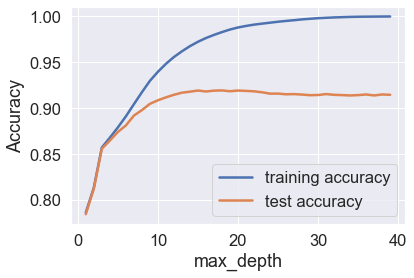

In [99]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(score["param_max_depth"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_max_depth"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

According to above plot, max_depth =10 is optimal

Tuning min_samples_leaf

In [100]:
# GridSearchCV to find optimal max_depth
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_leaf': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [101]:
# scores of GridSearch CV
score = tree.cv_results_
pd.DataFrame(score).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_leaf,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,1.93,0.02,0.01,0.00,5,{'min_samples_leaf': 5},0.87,0.92,0.92,0.91,...,0.91,0.02,1,0.97,0.97,0.96,0.97,0.96,0.97,0.00
1,1.66,0.13,0.00,0.00,25,{'min_samples_leaf': 25},0.87,0.90,0.90,0.90,...,0.90,0.01,2,0.92,0.92,0.92,0.92,0.92,0.92,0.00
2,1.31,0.10,0.01,0.00,45,{'min_samples_leaf': 45},0.88,0.89,0.90,0.89,...,0.89,0.01,3,0.91,0.90,0.90,0.90,0.91,0.91,0.00
3,1.29,0.03,0.00,0.00,65,{'min_samples_leaf': 65},0.88,0.89,0.89,0.89,...,0.89,0.01,4,0.90,0.90,0.90,0.90,0.90,0.90,0.00
4,1.23,0.05,0.00,0.00,85,{'min_samples_leaf': 85},0.88,0.89,0.89,0.89,...,0.89,0.01,5,0.90,0.89,0.89,0.89,0.89,0.89,0.00


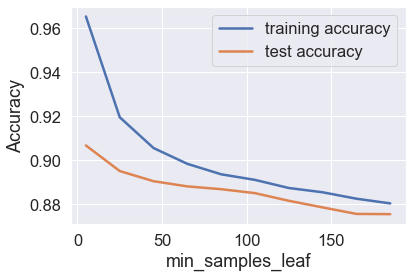

In [102]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(score["param_min_samples_leaf"], 
         score["mean_train_score"], 
         label="training accuracy")
plt.plot(score["param_min_samples_leaf"], 
         score["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_samples_leaf = 25 looks to be optimal

Tuning min_samples_split

In [103]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(5, 200, 20)}

# instantiate the model
dtree = DecisionTreeClassifier(criterion = "gini", 
                               random_state = 100)

# fit tree on training data
tree = GridSearchCV(dtree, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
tree.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=100),
             param_grid={'min_samples_split': range(5, 200, 20)},
             return_train_score=True, scoring='accuracy')

In [104]:
# scores of GridSearch CV
scores = tree.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,2.02,0.10,0.00,0.00,5,{'min_samples_split': 5},0.88,0.92,0.92,0.92,...,0.91,0.02,1,0.99,0.99,0.99,0.99,0.99,0.99,0.00
1,1.96,0.13,0.01,0.00,25,{'min_samples_split': 25},0.86,0.91,0.92,0.91,...,0.90,0.02,2,0.96,0.96,0.96,0.96,0.96,0.96,0.00
2,1.97,0.08,0.01,0.00,45,{'min_samples_split': 45},0.86,0.91,0.91,0.91,...,0.90,0.02,3,0.95,0.95,0.95,0.94,0.94,0.95,0.00
3,1.99,0.11,0.01,0.01,65,{'min_samples_split': 65},0.86,0.90,0.91,0.90,...,0.90,0.02,4,0.94,0.94,0.94,0.93,0.93,0.94,0.00
4,1.89,0.11,0.00,0.00,85,{'min_samples_split': 85},0.86,0.90,0.91,0.90,...,0.89,0.02,5,0.93,0.93,0.93,0.93,0.93,0.93,0.00


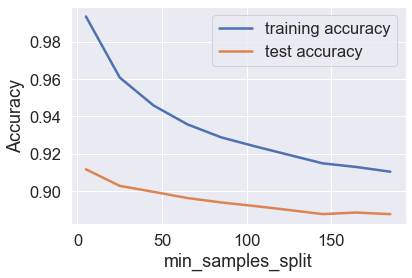

In [105]:
# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

min_samples_leaf=50 looks optimal

In [106]:
# Create the parameter grid 
param_grid = {
    'max_depth': range(5, 15, 5),
    'min_samples_leaf': range(25, 175, 50),
    'min_samples_split': range(50, 150, 50),
    'criterion': ["entropy", "gini"]
}

n_folds = 5

# Instantiate the grid search model
dtree = DecisionTreeClassifier()
grid_search = GridSearchCV(estimator = dtree, param_grid = param_grid, 
                          cv = n_folds, verbose = 1)

# Fit the grid search to the data
grid_search.fit(X_lasso, y_tr)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 120 out of 120 | elapsed:  2.1min finished


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(),
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': range(5, 15, 5),
                         'min_samples_leaf': range(25, 175, 50),
                         'min_samples_split': range(50, 150, 50)},
             verbose=1)

In [107]:
# cv results
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results
# printing the optimal accuracy score and hyperparameters
print("Best Accuracy", grid_search.best_score_)


Best Accuracy 0.8951944415606929


In [108]:
print(grid_search.best_estimator_)

DecisionTreeClassifier(criterion='entropy', max_depth=10, min_samples_leaf=25,
                       min_samples_split=50)


In [109]:
# model with optimal hyperparameters
clf_gini = DecisionTreeClassifier(criterion = "gini", 
                                  random_state = 100,
                                  max_depth=5, 
                                  min_samples_leaf=25,
                                  min_samples_split=50)
clf_gini.fit(X_lasso, y_tr)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=25, min_samples_split=50,
                       random_state=100)

In [110]:
# accuracy score
print ('Accuracy Score for Decision Tree Final Model :',clf_gini.score(X_test,y_test))

Accuracy Score for Decision Tree Final Model : 0.8769025663815132


#### Summary - Decision Tress
* Getting around 87% accuracy 
* Confusion matix shows lot of false positives still exist.
* 31 Features were selected for Model Building

### Random Forest

Random Forest with Default Hyperparameters

In [111]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics

model_rf = RandomForestClassifier()
model_rf.fit(X_lasso, y_tr)

# Make predictions
prediction_test = model_rf.predict(X_test)
print ('Randon Forest Accuracy with Default Hyperparameter',metrics.accuracy_score(y_test, prediction_test))

Randon Forest Accuracy with Default Hyperparameter 0.9263415176091545


In [112]:
print(classification_report(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.97      0.95      0.96      8272
           1       0.54      0.67      0.60       729

    accuracy                           0.93      9001
   macro avg       0.75      0.81      0.78      9001
weighted avg       0.94      0.93      0.93      9001



In [113]:
# Printing confusion matrix
print(confusion_matrix(y_test, prediction_test))

[[7848  424]
 [ 239  490]]


### Hyperparameter Tuning

Tuning max_depth

In [114]:
# GridSearchCV to find optimal n_estimators
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'max_depth': range(2, 20, 5)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'max_depth': range(2, 20, 5)}, return_train_score=True,
             scoring='accuracy')

In [115]:
# scores of GridSearch CV
scores = rf.cv_results_
pd.DataFrame(scores).head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_max_depth,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,...,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,split3_train_score,split4_train_score,mean_train_score,std_train_score
0,3.48,0.29,0.10,0.01,2,{'max_depth': 2},0.83,0.83,0.85,0.82,...,0.84,0.01,4,0.84,0.83,0.84,0.83,0.84,0.84,0.00
1,9.59,0.21,0.16,0.01,7,{'max_depth': 7},0.89,0.90,0.91,0.90,...,0.90,0.01,3,0.91,0.91,0.91,0.91,0.91,0.91,0.00
2,14.24,0.24,0.20,0.03,12,{'max_depth': 12},0.93,0.94,0.94,0.94,...,0.94,0.01,2,0.97,0.96,0.96,0.96,0.96,0.96,0.00
3,17.90,0.85,0.24,0.04,17,{'max_depth': 17},0.94,0.96,0.96,0.95,...,0.95,0.01,1,0.99,0.99,0.99,0.99,0.99,0.99,0.00


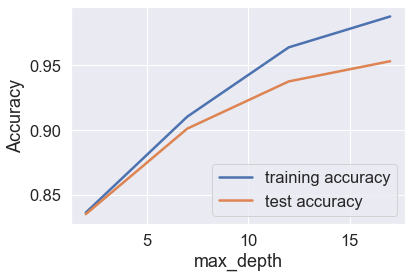

In [116]:
# plotting accuracies with max_depth
plt.figure()
plt.plot(scores["param_max_depth"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_max_depth"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("max_depth")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

> <span style='color:green'>**Analysis:** We can see that as we increase the value of max_depth, both train and test scores increase till a point, but after that test score becomme stagnant. The ensemble tries to overfit as we increase the max_depth. Thus, controlling the depth of the constituent trees will help reduce overfitting in the forest. **12 and 18** value have peek convergens and can be used for grid veiw search.

Tuning min_samples_leaf

In [117]:
# GridSearchCV to find optimal min_samples_leaf
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_leaf': range(50, 400, 10)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_leaf': range(50, 400, 10)},
             return_train_score=True, scoring='accuracy')

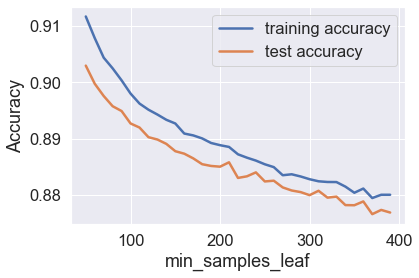

In [118]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_leaf
plt.figure()
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_leaf"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_leaf")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Tuning min_samples_split

In [119]:
# GridSearchCV to find optimal min_samples_split
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV


# specify number of folds for k-fold CV
n_folds = 5

# parameters to build the model on
parameters = {'min_samples_split': range(100, 500, 25)}

# instantiate the model
rf = RandomForestClassifier()


# fit tree on training data
rf = GridSearchCV(rf, parameters, 
                    cv=n_folds, 
                   scoring="accuracy",return_train_score=True)
rf.fit(X_lasso, y_tr)

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'min_samples_split': range(100, 500, 25)},
             return_train_score=True, scoring='accuracy')

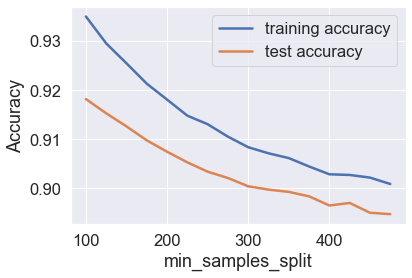

In [120]:
# scores of GridSearch CV
scores = rf.cv_results_

# plotting accuracies with min_samples_split
plt.figure()
plt.plot(scores["param_min_samples_split"], 
         scores["mean_train_score"], 
         label="training accuracy")
plt.plot(scores["param_min_samples_split"], 
         scores["mean_test_score"], 
         label="test accuracy")
plt.xlabel("min_samples_split")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

Grid Search to Find Optimal Hyperparameters

In [121]:
# Create the parameter grid based on the results of random search 
param_grid = {
    'max_depth': [4,8,10],
    'min_samples_leaf': range(100, 300, 100),
    'min_samples_split': range(200, 500, 100),
    'n_estimators': [500,700], 
    'max_features': [10,20,25]
}
# Create a based model
rf = RandomForestClassifier()
# Instantiate the grid search model
grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 3, n_jobs = -1,verbose = 1)

In [122]:
#Commenting as it takes long time
# Fit the grid search to the data
#grid_search.fit(X_lasso, y_tr)
# printing the optimal accuracy score and hyperparameters
#print('Accuracy is',grid_search.best_score_,'using',grid_search.best_params_)

In [123]:
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=101)

model_rf = RandomForestClassifier(bootstrap=True,
                                  max_depth=10,
                                  min_samples_leaf=100, 
                                  min_samples_split=200,
                                  n_estimators=1000 ,
                                  oob_score = True, n_jobs = -1,
                                  random_state =50,
                                  max_features = 15,
                                  max_leaf_nodes = 30)
model_rf.fit(X_train, y_train)

# Make predictions
prediction_test = model_rf.predict(X_test)

In [124]:
# evaluation metrics
from sklearn.metrics import classification_report,confusion_matrix
print(classification_report(y_test,prediction_test))
print(confusion_matrix(y_test,prediction_test))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97      5493
           1       0.73      0.41      0.52       508

    accuracy                           0.94      6001
   macro avg       0.84      0.70      0.75      6001
weighted avg       0.93      0.94      0.93      6001

[[5415   78]
 [ 300  208]]


In [125]:
# accuracy score
print ('Accuracy Score for Random Forest Final Model :',metrics.accuracy_score(y_test, prediction_test))

Accuracy Score for Random Forest Final Model : 0.9370104982502916


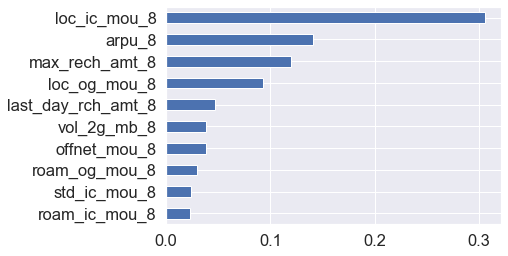

In [126]:
X = df
# Scaling all the variables to a range of 0 to 1
#from sklearn.preprocessing import MinMaxScaler
features = X.columns.values
X = pd.DataFrame(scaler.transform(X))
X.columns = features

importances = model_rf.feature_importances_
weights = pd.Series(importances,
                 index=X.columns.values)
weights.sort_values()[-10:].plot(kind = 'barh')

Observations:

* From random forest algorithm, Local Incoming for Month 8, Average Revenue Per Customer for Month 8 and Max Recharge Amount for Month 8 are the most important predictor variables to predict churn.
* The results from random forest are very similar to that of the logistic regression and in line to what we had expected from our EDA

### 7. Recommendations

> ### Business Insights 

> <span style='color:blue'> Less number of **high value customer** are churing but for last **6 month** no new high valued cusotmer is onboarded which is concerning and company should concentrate on that aspect. </span>

> <span style='color:blue'> Customers with less than **4 years** of tenure are more likely to churn and company should concentrate more on that segment by rolling out new schems to that group. 

> <span style='color:blue'> **Average revenue per user** seems to be most important feature in determining churn prediction. 

> <span style='color:blue'> **Incoming** and **Outgoing Calls** on **romaing** for 8th month are strong indicators of churn behaviour

> <span style='color:blue'> **Local Outgoing calls** made to landline , fixedline , mobile and call center provides a strong indicator of churn behaviour. 

> <span style='color:blue'> Better 2G/3G area coverage where 2G/3G services are not good, it's strong indicator of churn behaviour.

> ### Model Insights 

> <span style='color:blue'> **SVM** with tuned hyperparameters produce best result on this dataset with 0.92 accuracy.

> <span style='color:blue'> **Random forest** also produce good accuracy with 0.93 (default overfit model) and 0.90 with tuned hyperparameters.

> <span style='color:blue'> **As per our analysis SVM and Random forest produce best accuracy and models can be selected to predict churn data for future dataset or production.**

### ** 8. Summary : Telecom Churn**
* Very Less Amount of High Value customers are churning which is a good service indicator
* Large no of Customers are new to Telecom Company and fall under < 5 Yr Tenure
* Std Outgoing Calls and Revenue Per Customer are strong indicators of Churn
* People with less than 4 Yrs of Tenure are more likely to Churn
* Behaviour of Volume Based Cost is not a strong indicator of Churn
* Max Recharge Amount could be a good Churn Indicator
* Random Forest is the best method to Predict Churn followed by SVM, other models too do a fair job
* Behaviour is 8 Month can be the base of Churn Analysis
* Local Incoming and Outgoing Calls for 8th Month and Average Revenue in 8th Month are strong indicators of Churn Behaviour